In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
from scipy.stats import entropy
from scipy.interpolate import interp1d

import sys
sys.path.append('/content/drive/MyDrive/stock_prediction')
from TimeSeriesDataset import TimeSeriesDataset

import logging
import os
import torch.nn.utils.prune as prune

## Data Preparation & Preprocessing

In [ ]:
def load_configs(configs_filename):
    with open(configs_filename, 'r') as file:
        return json.load(file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Plot functions
def plot_last_prices(last_prices, normalized=True):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price' if normalized else 'Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices' if normalized else 'Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, period, period_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    for i in range(len(period)):
      t = period[i]
      period_label = period_labels[i]
      plt.plot(data.index, data[f'ma({t})'], label=f'{period_label} MA')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title('Prices with Moving Average')
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, short_period, long_period, signal_period):
    for i in range(len(short_period)):
      plt.figure(figsize=(10, 5))
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      plt.plot(data.index, data[f'macd_line({a},{b},{c})'], label=f'MACD')
      plt.plot(data.index, data[f'signal_line({a},{b},{c})'], label=f'Signal')
      plt.plot(data.index, data[f'macd_histogram({a},{b},{c})'], label=f'Histogram')
      plt.xlabel('Date')
      plt.ylabel('Convergence/Divergence')
      plt.title(f"MACD({a},{b},{c})")
      plt.legend()
      plt.show()

In [ ]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point

    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])

    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)

    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

In [ ]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))

    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)

        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)

    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time

    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]

    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)

    outside_intervals = ~np.vectorize(is_within_intervals)(times)

    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")

    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered.loc[:, 'volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()

    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)

    # Identify high volume segments
    data_filtered.loc[:, 'high_volume'] = data_filtered['volume_rolling'] > volume_threshold

    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered.loc[:, 'segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()

    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments.loc[:, 'volume'] = high_volume_segments['volume'].ffill()

    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)

    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time

    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values

    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()

        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask

        # Filter data by interval
        interval_data = data_array[interval_mask]
        clear_gpu_cache()
        if len(interval_data) == 0:
            continue

        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)

        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)

        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue

            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0

            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price

    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price

    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)

    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]

    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]

def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size])
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array


# Generator function
def data_generator(data_array, indices, num_steps, batch_size, last_price_index=0):
    total_len = len(indices)
    for start_idx in range(0, total_len, batch_size):
        end_idx = min(start_idx + batch_size, total_len)
        batch_indices = indices[start_idx:end_idx]
        X_batch = np.array([data_array[i: i + num_steps] for i in batch_indices])
        y_batch = data_array[batch_indices + num_steps, :, last_price_index]
        yield X_batch, y_batch


# Train-test split function
def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps

    X = np.empty((total_len, num_steps, input_size, data_array.shape[-1] - 1), dtype=np.float32)
    y = np.empty((total_len, num_steps), dtype=np.float32)

    for i in range(total_len):
        X[i] = data_array[i:i + num_steps, :, 1:]  # Exclude the last_price column (column 0)
        y[i] = data_array[i:i + num_steps, :, last_price_index]  # Store the last_price values

    # Check the shapes of X and y
    num_features = data_array.shape[-1] - 1  # Exclude the last_price column
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, num_steps), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"

    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))

    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

# Create dataloader instances
def create_dataloader_instances(dataset, val_split, test_split, batch_size, num_workers=8):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

# Create forward fill bid custom
def forward_fill_bid_custom(data, price_cols):
    # Forward fill NaN values across rows for specified columns
    data[price_cols] = data[price_cols].ffill(axis=1)

    # Forward fill NaN values across columns for specified columns
    data[price_cols] = data[price_cols].ffill(axis=0)

    return data

def clear_gpu_cache():
    torch.cuda.empty_cache()


# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=64):
    # Ensure no NaN values
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0

    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])

    # Plot the prices before normalization
    plot_last_prices(extended_segment[:, last_price_index], normalized=False)

    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)

    clear_gpu_cache()

    # Plot the prices after normalization
    plot_last_prices(extended_segment[:, last_price_index])

    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    clear_gpu_cache()

    # Create dataset and dataloader instances
    dataset = TimeSeriesDataset(extended_segment, num_steps, last_price_index)
    clear_gpu_cache()
    train_loader, val_loader, test_loader = create_dataloader_instances(dataset, val_split=val_split, test_split=test_split, batch_size=batch_size)
    clear_gpu_cache()

    # # Remove all rows with exceptionally small bid ask spread
    # extended_segment = extended_segment[:, ]

    return extended_segment, train_loader, val_loader, test_loader, dataset.num_features


def add_derived_features(extended_segment):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

    # Calculate Bid-Ask Spread
    extended_segment.loc[:, 'bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

    # Calculate Market Depth (total bid and ask volumes)
    extended_segment.loc[:, 'total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment.loc[:, 'total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

    # Calculate Order Imbalance Ratio
    extended_segment.loc[:, 'order_imbalance_ratio'] = (extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']) / (extended_segment['total_bid_volume'] + extended_segment['total_ask_volume'])

    # Calculate Volume Order Imbalance
    delta_bid_vol = extended_segment[bid_volume_cols].diff().fillna(0)
    delta_ask_vol = extended_segment[ask_volume_cols].diff().fillna(0)
    delta_bid_price = extended_segment[bid_price_cols].diff().fillna(0)
    delta_ask_price = extended_segment[ask_price_cols].diff().fillna(0)

    for i in range(1, 6):
        bid_vol_col = f'bid_volume{i}'
        ask_vol_col = f'ask_volume{i}'
        bid_price_col = f'bid_price{i}'
        ask_price_col = f'ask_price{i}'

        # Clip delta_bid_vol to bid_volume on a rise
        delta_bid_vol[bid_vol_col] = np.where(delta_bid_price[bid_price_col] > 0,
                                              np.minimum(delta_bid_vol[bid_vol_col], extended_segment[bid_vol_col]),
                                              delta_bid_vol[bid_vol_col])

        # Clip delta_ask_vol to ask_volume on a fall
        delta_ask_vol[ask_vol_col] = np.where(delta_ask_price[ask_price_col] < 0,
                                              np.minimum(delta_ask_vol[ask_vol_col], extended_segment[ask_vol_col]),
                                              delta_ask_vol[ask_vol_col])

    extended_segment.loc[:, 'volume_order_imbalance'] = delta_bid_vol.sum(axis=1) - delta_ask_vol.sum(axis=1)

    # Calculate Mid-Price Basis
    extended_segment.loc[:, 'mid_price'] = (extended_segment.loc[:, 'bid_price1'] + extended_segment.loc[:, 'ask_price1']) / 2

    # Calculate average trade price if it doesn't exist
    if 'average_trade_price' not in extended_segment.columns:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['mid_price']
        )
    else:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['average_trade_price'].shift(1).fillna(0)
        )

    extended_segment['mid_price_basis'] = extended_segment['average_trade_price'] - extended_segment['mid_price']

    # Drop intermediary derived feature columns
    intermediary_columns = [
        'total_bid_volume', 'total_ask_volume', 'mid_price', 'average_trade_price'
    ]
    extended_segment = extended_segment.drop(columns=intermediary_columns)

    # Ensure there are no NaN values
    assert not extended_segment.isnull().values.any(), "There are NaN values in the derived features"
    assert(np.isnan(extended_segment).sum().sum() == 0)


def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Compute Factors: MA & MACD
    for i in range(len(period)):
      # Calculate MA
      t = period[i]
      extended_segment[f'ma({t})'] = moving_average(extended_segment['last_price'], t)
      extended_segment[f'ma({t})'] = extended_segment[f'ma({t})'].fillna(method='ffill')

      # Calculate MACD
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], a, b, c)
      extended_segment[f'macd_line({a},{b},{c})'] = macd_line
      extended_segment[f'signal_line({a},{b},{c})'] = signal_line
      extended_segment[f'macd_histogram({a},{b},{c})'] = macd_histogram

    print(extended_segment.columns)

All times are within the specified intervals.


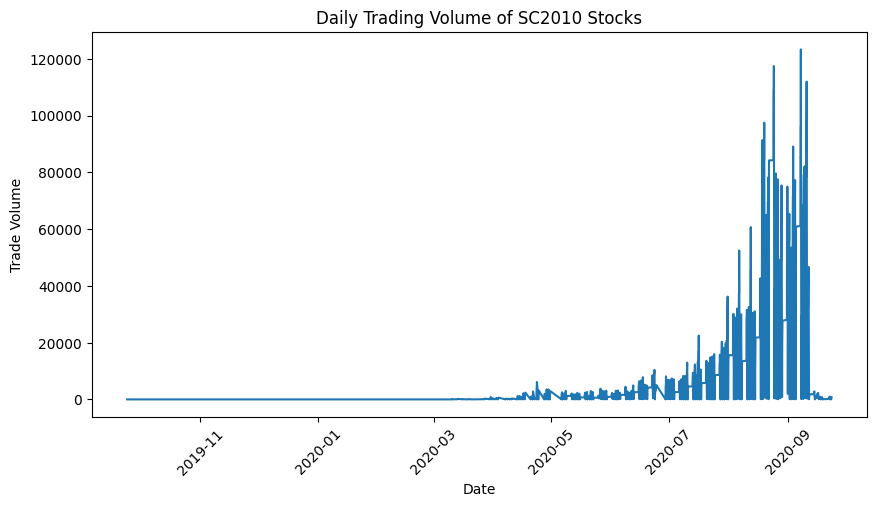

<ipython-input-6-a2339106dd48>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
<ipython-input-6-a2339106dd48>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'high_volume'] = data_filtered['volume_rolling'] > volume_threshold
<ipython-input-6-a2339106dd48>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

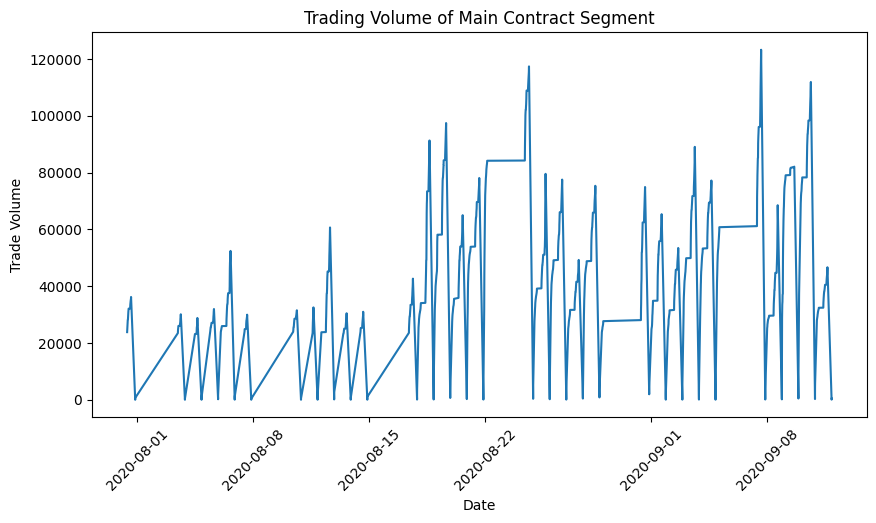

All times are within the specified intervals.


<ipython-input-6-a2339106dd48>:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=1)
<ipython-input-6-a2339106dd48>:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=0)
<ipython-input-6-a2339106dd48>:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Index(['last_price', 'highest', 'lowest', 'bid_price1', 'bid_volume1',
       'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4',
       'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1',
       'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4',
       'ask_volume4', 'ask_price5', 'ask_volume5', 'volume', 'amount',
       'open_interest', 'bid_ask_spread', 'total_bid_volume',
       'total_ask_volume', 'order_imbalance_ratio', 'volume_order_imbalance',
       'mid_price', 'average_trade_price', 'mid_price_basis', 'ma(5)',
       'macd_line(5,15,10)', 'signal_line(5,15,10)', 'macd_histogram(5,15,10)',
       'ma(10)', 'macd_line(10,20,20)', 'signal_line(10,20,20)',
       'macd_histogram(10,20,20)', 'ma(15)', 'macd_line(15,25,30)',
       'signal_line(15,25,30)', 'macd_histogram(15,25,30)', 'ma(20)',
       'macd_line(20,30,40)', 'signal_line(20,30,40)',
       'macd_histogram(20,30,40)'],
      dtype='object')


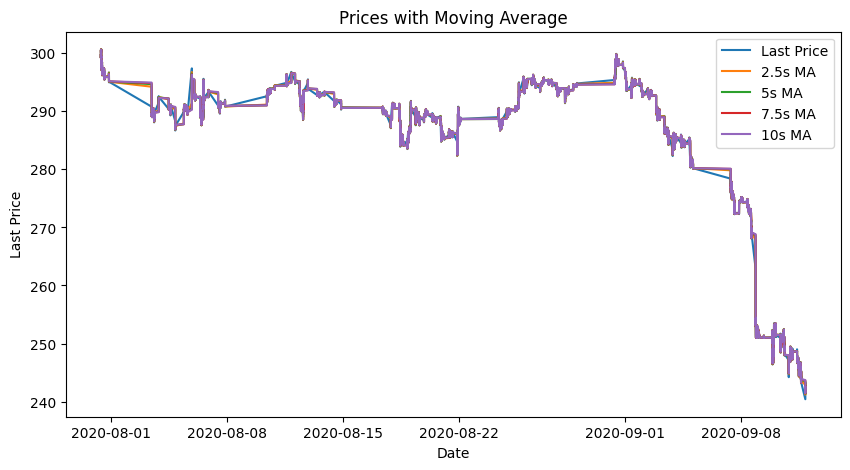

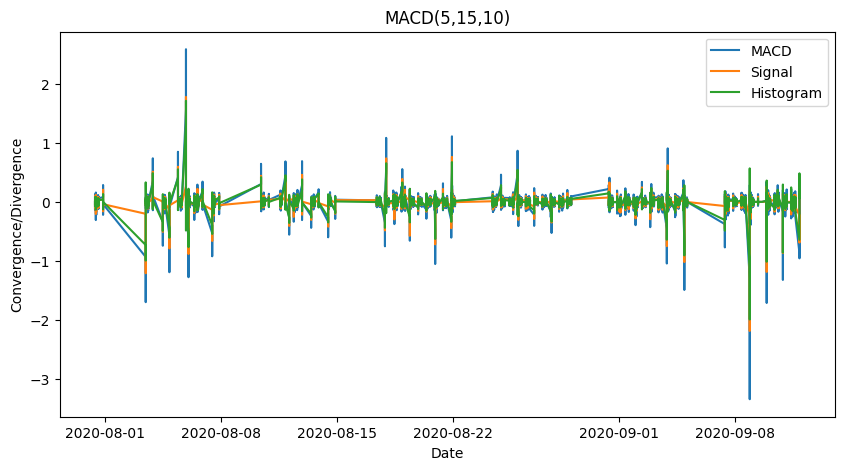

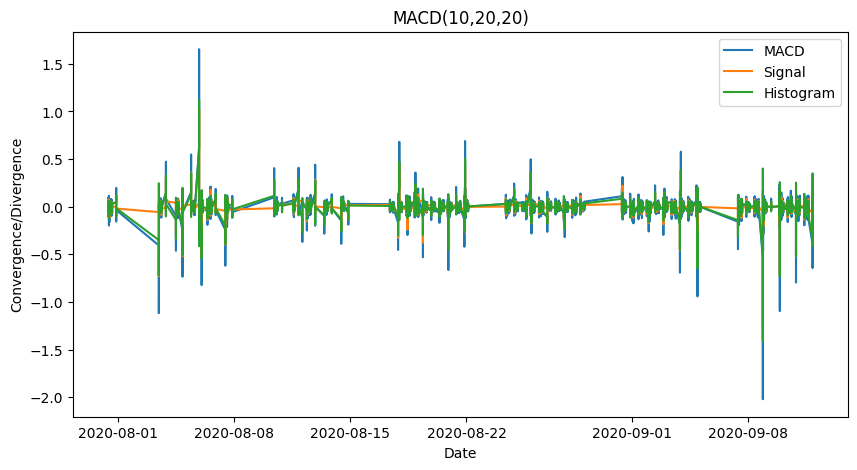

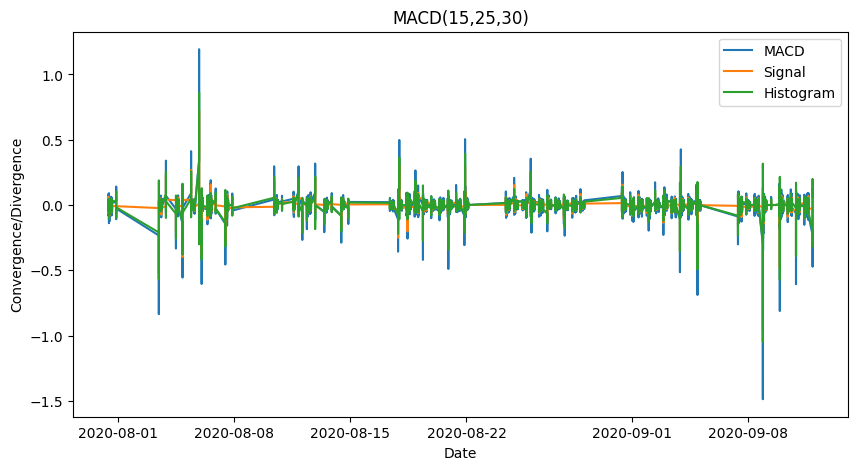

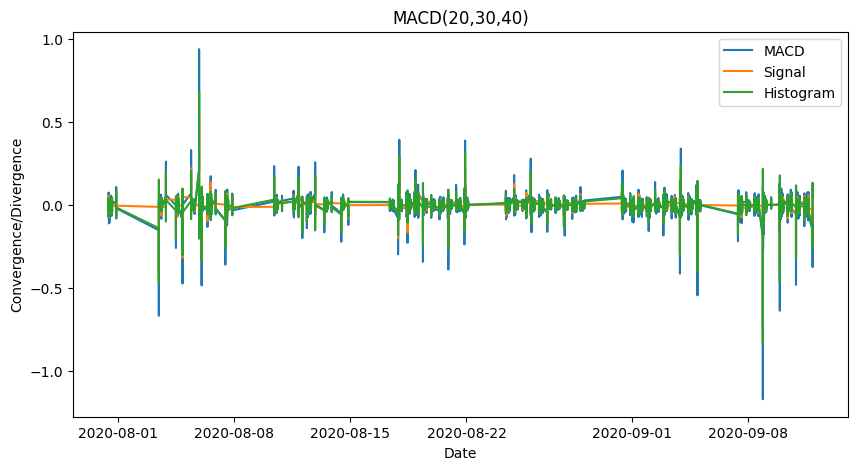

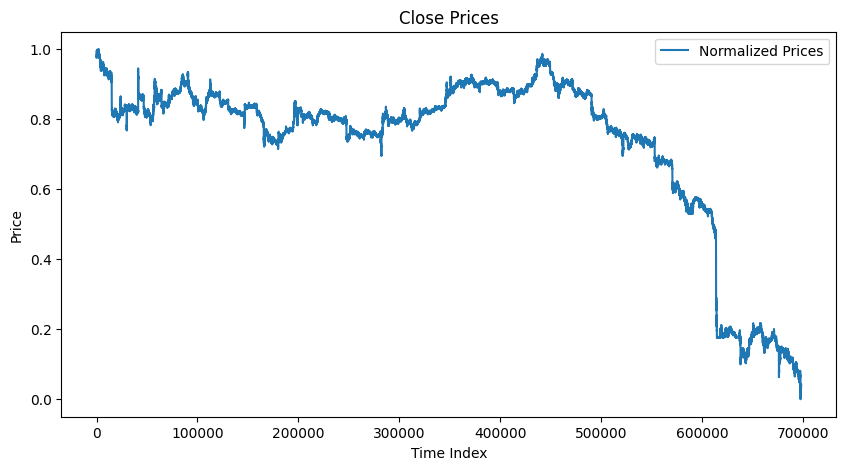

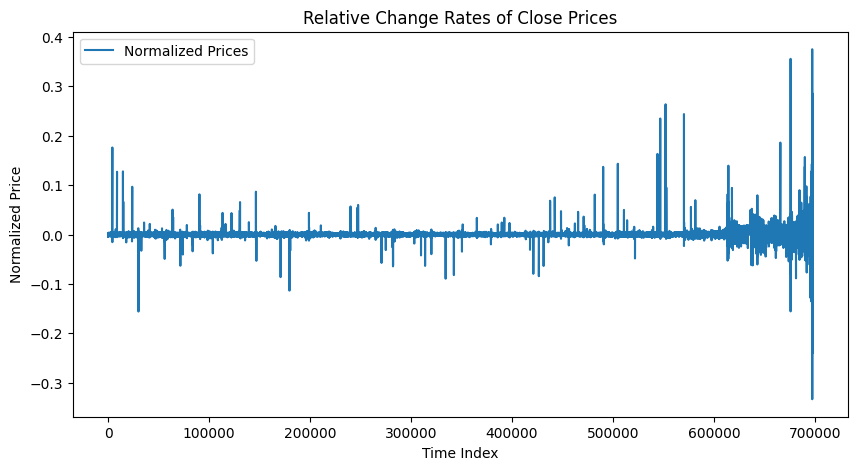

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Params
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]

# Define paths
configs_filepath = '/content/drive/MyDrive/stock_prediction/configs/configs.json'
dataset_filepath = '/content/drive/MyDrive/stock_prediction/data/INE.sc2010.csv'

# Load configs file
configs = load_configs(configs_filepath)
clear_gpu_cache()

# Read data
# data = pd.read_csv('data/' + dataset_filename + '.csv')
data = pd.read_csv(dataset_filepath)
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)

with cProfile.Profile() as pr:
    # Only include data within the specified intervals
    data_filtered = filter_data_by_intervals(data, intervals)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(data_filtered, intervals)
    # pr.print_stats()

    # Plot trading volume data
    plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')

    # Extract the main contract
    # data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning
    # pr.print_stats()
    data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
    # pr.print_stats()
    extended_segment = extract_main_contract(data_filtered)
    # pr.print_stats()

    # Plot main contract segment
    plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
    # pr.print_stats()

    # Set index of the resulting dataframe
    extended_segment.set_index('datetime', inplace=True)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(extended_segment, intervals)
    # pr.print_stats()

    # Extract needed hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    normalize = configs['normalize']
    batch_size = configs['batch_size']

    # Add derived features
    add_derived_features(extended_segment)

    # Add factors
    period_labels = np.array(['2.5s', '5s', '7.5s', '10s'])
    period = np.array([5, 10, 15, 20])
    short_period = period
    long_period = period + 10
    signal_period = 2 * period

    add_factors(extended_segment, short_period, long_period, signal_period, period)
    # pr.print_stats()

    # Plot closing prices with factors
    plot_prices_with_ma(extended_segment, period, period_labels)
    plot_prices_with_macd(extended_segment, short_period, long_period, signal_period)

    # Normalize data
    extended_segment = normalize_data(extended_segment)
    assert(extended_segment.isna().sum().sum() == 0)

    # Create sequences based on the extended_segment
    extended_segment, train_loader, val_loader, test_loader, num_features = create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=batch_size)

## RNN Model Definition

Include quantized components when Quantized-Aware Training (QAT) enabled.

In [ ]:
def convert_to_labels(val, flat_gap=0.01):
    return 2 if val > flat_gap else 0 if val < -flat_gap else 1

In [ ]:
def classification_accuracy(y_pred, y_true):
    y_pred_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_pred)])
    y_true_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_true)])
    return torch.sum(y_pred_labels == y_true_labels) / len(y_true_labels)

In [ ]:
# Utility function to fake quantize input to specified bit-width with stochastic rounding
def fake_quantize(x, scale, zero_point, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    x = x.to(torch.float32)
    qx = x / scale + zero_point

    if stochastic:
        qx = torch.floor(qx + torch.rand_like(qx))
    else:
        qx = torch.round(qx)

    qx = qx.clamp(qmin, qmax)
    return qx * scale - zero_point

def analyze_output_distribution(outputs, title="Output Distribution"):
    outputs = outputs.detach().cpu().numpy()
    if np.isnan(outputs).any():
        print(f"Warning: NaN values detected in {title}")
        return
    plt.hist(outputs.flatten(), bins=100)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Per-channel quantization function
def fake_quantize_per_channel(tensor, scales, zero_points, axis=0, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    scales = scales.unsqueeze(axis).expand_as(tensor)
    zero_points = zero_points.unsqueeze(axis).expand_as(tensor)
    quantized_tensor = tensor / scales + zero_points

    if stochastic:
        quantized_tensor = torch.floor(quantized_tensor + torch.rand_like(quantized_tensor))
    else:
        quantized_tensor = torch.round(quantized_tensor)

    quantized_tensor = quantized_tensor.clamp(qmin, qmax)
    return quantized_tensor * scales - zero_points

# Dynamic adjustment of scale and zero-point per channel based on output distribution
def update_scale_and_zero_point_per_channel(tensor, axis=0, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    tensor_min = tensor.min(dim=axis, keepdim=True).values
    tensor_max = tensor.max(dim=axis, keepdim=True).values

    scale = (tensor_max - tensor_min) / (qmax - qmin)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)
    zero_point = torch.round(qmin - tensor_min / scale).int().clamp(qmin, qmax)

    return scale.squeeze(dim=axis), zero_point.squeeze(dim=axis)

# Update scale and zero-point with proper bit-width support
def update_scale_and_zero_point(x, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1

    min_val, max_val = x.min().item(), x.max().item()

    if min_val == max_val:
        scale = 1.0
        zero_point = 0
    else:
        scale = (max_val - min_val) / (qmax - qmin)
        zero_point = qmin - min_val / scale
        zero_point = torch.round(torch.tensor(zero_point)).int().clamp(qmin, qmax)

    return scale, zero_point

# Function to dynamically update scale and zero-point per channel
def update_scale_and_zero_point_per_channel(tensor, axis=0, num_bits=8):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    tensor_min = tensor.min(dim=axis, keepdim=True).values
    tensor_max = tensor.max(dim=axis, keepdim=True).values

    scale = (tensor_max - tensor_min) / (qmax - qmin)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)
    zero_point = torch.round(qmin - tensor_min / scale).int().clamp(qmin, qmax)

    return scale.squeeze(dim=axis), zero_point.squeeze(dim=axis)

# Quantize tensor with specified bit-width and stochastic rounding
def quantize_tensor(tensor, scale, zero_point, num_bits=8, stochastic=False):
    qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
    q_tensor = tensor / scale + zero_point

    if stochastic:
        q_tensor = torch.floor(q_tensor + torch.rand_like(q_tensor))
    else:
        q_tensor = torch.round(q_tensor)

    q_tensor_new = torch.clamp(q_tensor, qmin, qmax)
    return q_tensor_new

# Quantize tensor per channel with specified bit-width and stochastic rounding
def quantize_per_channel(tensor, axis=0, num_bits=8, stochastic=False):
    scales, zero_points = update_scale_and_zero_point_per_channel(tensor, axis=axis, num_bits=num_bits)
    quantized_tensor = fake_quantize_per_channel(tensor, scales, zero_points, axis=axis, num_bits=num_bits, stochastic=stochastic)
    return quantized_tensor, scales, zero_points

# Quantize-and-dequantize operation for analysis and calibration
def quantize_and_dequantize(x, scale, zero_point, num_bits=8, stochastic=False):
    q_tensor = fake_quantize(x, scale, zero_point, num_bits=num_bits, stochastic=stochastic)
    deq_tensor = dequantize_tensor(q_tensor, scale, zero_point)
    return deq_tensor

# Per-layer quantization analysis with dynamic scale adjustment
def per_layer_analysis(layers, inputs):
    for i, layer in enumerate(layers):
        with torch.no_grad():
            outputs = layer(inputs)
            analyze_output_distribution(outputs, f"Layer {i+1} Output Distribution")

            # Update scales and zero-points dynamically during analysis
            scale, zero_point = update_scale_and_zero_point(outputs, num_bits=8)
            outputs = quantize_and_dequantize(outputs, scale, zero_point)

            inputs = outputs

# Dequantize tensor back to float
def dequantize_tensor(q_tensor, scale, zero_point):
    if not isinstance(scale, torch.Tensor):
        scale = torch.tensor(scale, dtype=torch.float32, device=q_tensor.device)
    if not isinstance(zero_point, torch.Tensor):
        zero_point = torch.tensor(zero_point, dtype=torch.float32, device=q_tensor.device)
    return (q_tensor.to(torch.float32) - zero_point) * scale

# Export model parameters with bit-width support
def export_model_parameters(model, filepath):
    model_params = {}

    for name, param in model.named_parameters():
        if param.dim() > 0:  # Ensure we're not trying to quantize a 0-dim tensor
            q_tensor, scales, zero_points = quantize_per_channel(param, num_bits=model.num_bits)
            model_params[name] = {
                "weights": q_tensor.tolist(),
                "scales": scales.tolist(),
                "zero_points": zero_points.tolist()
            }
        else:
            # For 0-dim tensors, handle separately
            model_params[name] = {
                "weights": [param.item()],
                "scales": [1.0],
                "zero_points": [0]
            }

    with open(filepath, 'w') as f:
        json.dump(model_params, f, indent=4)

# Log tensor information for debugging
def log_tensor_info(tensor, name):
    print(f"{name} shape: {tensor.shape}")
    print(f"{name} min: {tensor.min()}, max: {tensor.max()}")
    print(f"{name} mean: {tensor.to(torch.float32).mean()}")
    assert not torch.isnan(tensor).any(), f"{name} contains NaN values!"

In [ ]:
# Custom LayerNorm for internal normalization in the LSTMCell
class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(CustomLayerNorm, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return (x - mean) / torch.sqrt(var + self.eps)

In [ ]:
class FakeQuantizationFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, zero_point, num_bits):
        # Forward pass remains the same
        ctx.save_for_backward(x, scale, zero_point)
        ctx.num_bits = num_bits
        qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
        x_q = torch.round(x / scale + zero_point)
        x_q_ = torch.clamp(x_q, qmin, qmax)
        x_q_new = (x_q_ - zero_point) * scale
        return x_q_new

    @staticmethod
    def backward(ctx, grad_output):
        x, scale, zero_point = ctx.saved_tensors
        num_bits = ctx.num_bits
        qmin, qmax = -(1 << (num_bits - 1)), (1 << (num_bits - 1)) - 1
        x_q = torch.round(x / scale + zero_point)
        x_q_clamped = torch.clamp(x_q, qmin, qmax)
        grad_input = grad_output / scale
        grad_scale = grad_output * (x_q_clamped - zero_point).sum() / scale
        grad_zero_point = -grad_output * (x_q_clamped - zero_point).sum()
        return grad_input, grad_scale, grad_zero_point, None

In [ ]:
# Custom LSTM Cell with quantization
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize
        self.num_bits = num_bits
        self.stochastic = stochastic

        self.W_i = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_c = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        self.batch_norm = CustomLayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        return quantize_and_dequantize(x, scale, zero_point, self.num_bits, stochastic=self.stochastic)

    def quantize_weights(self, W):
        scale, zero_point = update_scale_and_zero_point_per_channel(W, axis=0, num_bits=self.num_bits)
        W_q = fake_quantize_per_channel(W, scale, zero_point, axis=0, num_bits=self.num_bits, stochastic=self.stochastic)
        return W_q, scale, zero_point

    def forward(self, x, h, c):
        if self.quantize:
            # Quantize input x
            scale_x, zero_point_x = update_scale_and_zero_point(x, self.num_bits)
            x_q = self.quantize_and_dequantize(x, scale_x, zero_point_x)

            # Quantize weights
            W_i_q, scale_w_i, zero_point_w_i = self.quantize_weights(self.W_i)
            U_i_q, scale_u_i, zero_point_u_i = self.quantize_weights(self.U_i)
            b_i_q = fake_quantize(self.b_i, scale_w_i.mean(), zero_point_w_i.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_f_q, scale_w_f, zero_point_w_f = self.quantize_weights(self.W_f)
            U_f_q, scale_u_f, zero_point_u_f = self.quantize_weights(self.U_f)
            b_f_q = fake_quantize(self.b_f, scale_w_f.mean(), zero_point_w_f.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_o_q, scale_w_o, zero_point_w_o = self.quantize_weights(self.W_o)
            U_o_q, scale_u_o, zero_point_u_o = self.quantize_weights(self.U_o)
            b_o_q = fake_quantize(self.b_o, scale_w_o.mean(), zero_point_w_o.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_c_q, scale_w_c, zero_point_w_c = self.quantize_weights(self.W_c)
            U_c_q, scale_u_c, zero_point_u_c = self.quantize_weights(self.U_c)
            b_c_q = fake_quantize(self.b_c, scale_w_c.mean(), zero_point_w_c.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            # Compute gates
            i_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_i_q.float().t()) + torch.mm(h, U_i_q.float().t()) + b_i_q))
            f_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_f_q.float().t()) + torch.mm(h, U_f_q.float().t()) + b_f_q))
            o_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_o_q.float().t()) + torch.mm(h, U_o_q.float().t()) + b_o_q))
            c_hat_t = torch.tanh(self.dropout(torch.mm(x_q, W_c_q.float().t()) + torch.mm(h, U_c_q.float().t()) + b_c_q))

        else:
            # Without quantization
            i_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_i.t()) + torch.mm(h, self.U_i.t()) + self.b_i))
            f_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_f.t()) + torch.mm(h, self.U_f.t()) + self.b_f))
            o_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_o.t()) + torch.mm(h, self.U_o.t()) + self.b_o))
            c_hat_t = torch.tanh(self.dropout(torch.mm(x, self.W_c.t()) + torch.mm(h, self.U_c.t()) + self.b_c))

        # Compute the new cell state
        c_t = f_t * c + i_t * c_hat_t

        # Apply LayerNorm to c_t
        c_t = self.batch_norm(c_t)

        # Compute the new hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h, c = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t, new_c = layer(x_t, h, c)

                # # Apply per-layer analysis after each layer's output
                # analyze_output_distribution(x_t, f"Layer {i+1} at time step {t+1} Output Distribution")

                hidden_states[i] = (x_t, new_c)

            outputs.append(x_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        h = torch.zeros(batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c = torch.zeros(batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return h, c

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize

In [ ]:
# Custom GRU Cell with quantization support
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.1, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize
        self.num_bits = num_bits
        self.stochastic = stochastic

        self.W_z = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))

        self.W_r = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))

        self.W_h = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))

        self.batch_norm = CustomLayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        return quantize_and_dequantize(x, scale, zero_point, self.num_bits, stochastic=self.stochastic)

    def quantize_weights(self, W):
        scale, zero_point = update_scale_and_zero_point_per_channel(W, axis=0, num_bits=self.num_bits)
        W_q = fake_quantize_per_channel(W, scale, zero_point, axis=0, num_bits=self.num_bits, stochastic=self.stochastic)
        return W_q, scale, zero_point

    def forward(self, x, h):
        if self.quantize:
            # Quantize input x
            scale_x, zero_point_x = update_scale_and_zero_point(x, self.num_bits)
            x_q = self.quantize_and_dequantize(x, scale_x, zero_point_x)

            # Quantize weights
            W_z_q, scale_w_z, zero_point_w_z = self.quantize_weights(self.W_z)
            U_z_q, scale_u_z, zero_point_u_z = self.quantize_weights(self.U_z)
            b_z_q = fake_quantize(self.b_z, scale_w_z.mean(), zero_point_w_z.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_r_q, scale_w_r, zero_point_w_r = self.quantize_weights(self.W_r)
            U_r_q, scale_u_r, zero_point_u_r = self.quantize_weights(self.U_r)
            b_r_q = fake_quantize(self.b_r, scale_w_r.mean(), zero_point_w_r.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            W_h_q, scale_w_h, zero_point_w_h = self.quantize_weights(self.W_h)
            U_h_q, scale_u_h, zero_point_u_h = self.quantize_weights(self.U_h)
            b_h_q = fake_quantize(self.b_h, scale_w_h.mean(), zero_point_w_h.float().mean(), num_bits=self.num_bits, stochastic=self.stochastic)

            # Compute gates
            z_t = torch.sigmoid(torch.mm(x_q, W_z_q.float().t()) + torch.mm(h, U_z_q.float().t()) + b_z_q)
            r_t = torch.sigmoid(torch.mm(x_q, W_r_q.float().t()) + torch.mm(h, U_r_q.float().t()) + b_r_q)
            h_tilda = torch.tanh(torch.mm(x_q, W_h_q.float().t()) + r_t * torch.mm(h, U_h_q.float().t()) + b_h_q)
        else:
            # Without quantization
            z_t = torch.sigmoid(torch.mm(x, self.W_z.t()) + torch.mm(h, self.U_z.t()) + self.b_z)
            r_t = torch.sigmoid(torch.mm(x, self.W_r.t()) + torch.mm(h, self.U_r.t()) + self.b_r)
            h_tilda = torch.tanh(torch.mm(x, self.W_h.t()) + r_t * torch.mm(h, self.U_h.t()) + self.b_h)

        # Compute the new hidden state
        h_next = (1 - z_t) * h + z_t * h_tilda

        # Apply LayerNorm to h_next
        h_next = self.batch_norm(h_next)

        return h_next

class CustomGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomGRUCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t = layer(x_t, h)
                hidden_states[i] = x_t
            # Append output from last layer
            outputs.append(x_t)

        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim)

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize


class CustomGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False, num_bits=8, stochastic=False):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize
        self.num_bits = num_bits

        self.layers = nn.ModuleList([
            CustomGRUCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize, num_bits, stochastic=stochastic)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]

        outputs = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t = layer(x_t, h)
                hidden_states[i] = x_t
            # Append output from last layer
            outputs.append(x_t)

        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim)

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits
        for layer in self.layers:
            layer.num_bits = num_bits

    def set_quantization(self, quantize):
        self.quantize = quantize
        for layer in self.layers:
            layer.quantize = quantize

In [ ]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, quantize=False, num_bits=8):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.quantize = quantize
        self.num_bits = num_bits
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.quantized = False

        self.init_weights()
        self.scale_w = None
        self.zero_point_w = None

    def init_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def quantize_and_dequantize(self, x, scale, zero_point):
        if scale is None or zero_point is None:
            raise ValueError("Quantization parameters (scale and zero_point) must be set before quantization.")

        if not isinstance(scale, torch.Tensor):
            scale = torch.tensor(scale, dtype=torch.float, device=x.device, requires_grad=False)
        if not isinstance(zero_point, torch.Tensor):
            zero_point = torch.tensor(zero_point, dtype=torch.float, device=x.device, requires_grad=False)

        return FakeQuantizationFunction.apply(x, scale, zero_point, self.num_bits)

    def forward(self, x):
        # Reshape x to 2D: (batch_size * num_steps, input_size)
        batch_size, num_steps, _ = x.size()
        x = x.view(-1, self.in_features)

        if self.quantize:
            # Quantize weights and perform matrix multiplication
            quantized_weight = self.quantize_and_dequantize(self.weight, self.scale_w, self.zero_point_w)
            output = torch.mm(x, quantized_weight.t())
        else:
            # Use the non-quantized weights
            output = torch.mm(x, self.weight.t())

        if self.bias is not None:
            output += self.bias

        # Reshape output back to 3D: (batch_size, num_steps, out_features)
        output = output.view(batch_size, num_steps, self.out_features)

        return output

    def set_quantization_bits(self, num_bits):
        self.num_bits = num_bits  # Set bit precision dynamically

    def set_quantization(self, quantize):
        self.quantize = quantize
        if self.quantize:
            # Initialize quantization parameters (for example, you may set them to specific values or compute them)
            self.scale_w = torch.tensor(1.0)  # Set a default value or compute the scale
            self.zero_point_w = torch.tensor(0)  # Set a default value or compute the zero point
        else:
            # Reset quantization parameters when not quantizing
            self.scale_w, self.zero_point_w = None, None

In [ ]:
class CustomRNNModel(nn.Module):
    def __init__(self, num_steps=20, input_size=10, hidden_units=128, num_layers=3, dropout_rate=0.1, quantize=False, rnn_type='lstm', num_bits=8, stochastic=False):
        super(CustomRNNModel, self).__init__()
        self.quantize = quantize
        self.rnn_type = rnn_type
        self.num_bits = num_bits

        # Select RNN type
        if rnn_type == 'lstm':
            self.rnn = CustomLSTM(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize, num_bits=num_bits, stochastic=stochastic)
        elif rnn_type == 'gru':
            self.rnn = CustomGRU(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize, num_bits=num_bits)

        self.fc = CustomLinear(hidden_units, input_size, quantize=quantize, num_bits=num_bits)  # CustomLinear layer with quantization

        self.init_weights()

        # Assign names to RNN layers for easy quantization handling
        for layer_idx, layer in enumerate(self.rnn.layers):
            for name, param in layer.named_parameters():
                name = name.replace('.', '_')
                self.register_buffer(f'rnn{layer_idx}_{name}', param)

        # Assign names to linear layers
        for name, param in self.fc.named_parameters():
            name = name.replace('.', '_')
            self.register_buffer(f'fc_{name}', param)

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'fc' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'b' in name:
                nn.init.constant_(param, 0.0)

    def set_quantization_bits(self, num_bits):
        self.quantization_bits = num_bits
        self.rnn.set_quantization_bits(num_bits)
        self.fc.set_quantization_bits(num_bits)

    def quantize(self, x):
        scale = 2 ** (self.quantization_bits - 1) - 1
        return torch.round(x * scale) / scale

    def forward(self, x):
        # Reshape input to batch_size, num_steps, input_size
        batch_size, num_steps, input_size, num_features = x.shape
        x = torch.reshape(x, (batch_size, num_steps, input_size * num_features))

        # Pass input through RNN
        rnn_output = self.rnn(x)

        # Apply the fully connected layer on the output of the last time step
        output = self.fc(rnn_output)

        output = torch.reshape(output, (batch_size, num_steps, input_size))

        return output

    def set_quantization(self, quantize):
        self.quantize = quantize
        self.rnn.set_quantization(quantize)
        self.fc.set_quantization(quantize)

In [ ]:
# def stepwise_quantization_schedule(epoch):
#     if epoch < 10:
#         return 16
#     elif epoch < 20:
#         return 12
#     else:
#         return 8

# def linear_decay_quantization_schedule(epoch, total_epochs):
#     return max(8, 16 - (8 * epoch / total_epochs))

# def adaptive_quantization_schedule(epoch, validation_loss, threshold=2e-5):
#     if epoch < 10:
#         return 16
#     elif validation_loss > threshold:  # Define your own threshold
#         return 12
#     else:
#         return 8

# def dynamic_quantization_schedule(epoch, total_epochs):
#     if epoch < 5:
#         return 16
#     elif epoch < 20:
#         return max(8, 16 - (8 * (epoch - 5) / (total_epochs - 5)))
#     else:
#         # Optional: adjust based on final performance if needed
#         return 8

# def exponential_quantization_schedule(epoch, total_epochs):
#     decay_rate = 0.1  # Adjust this based on how quickly you want to decay
#     min_bits = 8
#     max_bits = 16
#     return max(min_bits, max_bits * math.exp(-decay_rate * epoch))

In [ ]:
def custom_loss(y_pred, y_true, y_pred_quantized, criterion):
    # Calculate standard loss
    standard_loss = criterion(y_pred, y_true)

    # Calculate quantization loss
    quantization_loss = criterion(y_pred_quantized, y_true)

    # Calculate difference between quantized vs non-quantized predictions
    quantization_diff = criterion(y_pred_quantized, y_pred)

    # Calculate quantization percent error
    quant_percent_error = torch.mean(torch.abs((y_pred - y_pred_quantized) / (y_pred.abs() + 1e-8)))

    # Calculate total loss as a weighted sum of standard and quantization losses
    total_loss = standard_loss + quantization_loss + quantization_diff

    # Return the total loss and the updated alpha
    return total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error

In [ ]:
def save_checkpoint(state, model, filename='checkpoint.pth.tar'):
    """Save the training model's state as a checkpoint, including pruning masks."""
    state['pruning_masks'] = {name: param.clone() for name, param in model.named_buffers() if 'mask' in name}
    print("Saving checkpoint...")
    torch.save(state, filename)

def load_checkpoint(model, optimizer, scheduler, sparsity_factor=0.0, max_sparsity_increment=0.01, total_sparsity=0.0, filename='checkpoint.pth.tar'):
    """Load a training checkpoint if it exists and reapply pruning."""
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        current_bits = checkpoint['current_bits']
        patience = checkpoint['patience']
        sparsity_factor = checkpoint.get('sparsity_factor', sparsity_factor)
        max_sparsity_increment = checkpoint.get('max_sparsity_increment', max_sparsity_increment)
        total_sparsity = checkpoint.get('total_sparsity', total_sparsity)
        nan_epochs = checkpoint.get('nan_epochs', 0)
        pruning_stopped = checkpoint.get('pruning_stopped', False)

        # Reapply pruning masks
        if 'pruning_masks' in checkpoint:
            for name, mask in checkpoint['pruning_masks'].items():
                if hasattr(model, name):
                    setattr(model, name, mask)

        print(f"Checkpoint loaded successfully from '{filename}' at epoch {start_epoch}, with {current_bits} bits and sparsity factor {sparsity_factor}")
        return start_epoch, best_val_loss, current_bits, patience, sparsity_factor, max_sparsity_increment, total_sparsity, nan_epochs, pruning_stopped
    else:
        print(f"No checkpoint found at '{filename}'. Starting from scratch.")
        return 0, float('inf'), None, 0, sparsity_factor, max_sparsity_increment, total_sparsity, 0, False

In [ ]:
def plot_output_distributions(y_pred, y_pred_quantized, title="Output Distribution Comparison"):
    plt.figure(figsize=(12, 6))
    sns.histplot(y_pred, color="blue", label="Non-Quantized", kde=True)
    sns.histplot(y_pred_quantized, color="red", label="Quantized", kde=True)
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_confusion_matrix(y_true, y_pred, y_pred_quantized):
    cm_non_quantized = confusion_matrix(y_true, y_pred.argmax(axis=1))
    cm_quantized = confusion_matrix(y_true, y_pred_quantized.argmax(axis=1))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_non_quantized, annot=True, fmt="d", cmap="Blues")
    plt.title("Non-Quantized Model")
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_quantized, annot=True, fmt="d", cmap="Reds")
    plt.title("Quantized Model")
    plt.show()

In [ ]:
def apply_gradient_based_pruning(model, sparsity=0.3):
    """
    Apply gradient-based pruning to the weights of LSTM/GRU layers.
    :param model: the CustomRNNModel object (LSTM/GRU model)
    :param sparsity: the sparsity level to apply (0.3 means 30% of the weights will be pruned)
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                weight_tensor = getattr(module, weight_name)

                if weight_tensor.requires_grad:
                    weight_tensor.retain_grad()

                if weight_tensor.grad is not None:
                    gradients = torch.abs(weight_tensor.grad)
                    threshold = torch.quantile(gradients, sparsity)
                    mask = gradients > threshold

                    # Apply mask manually to prune weights
                    pruned_weight_tensor = weight_tensor * mask.float()

                    # Assign pruned weights back to the model
                    setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

        elif isinstance(module, CustomGRUCell):
            for weight_name in ['W_r', 'W_z', 'W_h']:
                weight_tensor = getattr(module, weight_name)

                if weight_tensor.requires_grad:
                    weight_tensor.retain_grad()

                if weight_tensor.grad is not None:
                    gradients = torch.abs(weight_tensor.grad)
                    threshold = torch.quantile(gradients, sparsity)
                    mask = gradients > threshold

                    pruned_weight_tensor = weight_tensor * mask.float()
                    setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

def apply_magnitude_based_pruning(model, sparsity=0.3):
    """
    Apply magnitude-based pruning to the weights of LSTM/GRU layers.
    :param model: the CustomRNNModel object (LSTM/GRU model)
    :param sparsity: the sparsity level to apply (0.3 means 30% of the weights will be pruned)
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

        elif isinstance(module, CustomGRUCell):
            for weight_name in ['W_r', 'W_z', 'W_h']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))


def apply_combined_pruning(model, grad_sparsity=0.05, mag_sparsity=0.05, sparsity_dict=None, current_sparsity_factor=1.0, target_sparsity=0.6, min_remaining_percentage=39.0):
    """
    Apply gradient-based, magnitude-based, and layer-specific pruning in combination.
    The current_sparsity_factor controls the dynamic increase in pruning as training progresses.
    Pruning stops once the model reaches close to 32% remaining weights.
    """
    grad_sparsity *= current_sparsity_factor
    mag_sparsity *= current_sparsity_factor

    # Calculate current model sparsity
    actual_sparsity, percent_remaining = calculate_sparsity(model)

    # If model has reached or exceeded the minimum remaining percentage, stop pruning
    if percent_remaining <= min_remaining_percentage:
        print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
        return actual_sparsity, percent_remaining  # Return without further pruning

    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # Gradient-based pruning
            apply_gradient_based_pruning(module, grad_sparsity)

            # Magnitude-based pruning
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o'] if isinstance(module, CustomLSTMCell) else ['W_r', 'W_z', 'W_h']:
                weights = torch.abs(getattr(module, weight_name))
                threshold = torch.quantile(weights, mag_sparsity)
                mask = weights > threshold

                pruned_weight_tensor = getattr(module, weight_name) * mask.float()
                setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

    # Recalculate the actual sparsity and return the updated values
    actual_sparsity, percent_remaining = calculate_sparsity(model)
    return actual_sparsity, percent_remaining

# def apply_combined_pruning(model, grad_sparsity=0.05, mag_sparsity=0.05, sparsity_dict=None, current_sparsity_factor=1.0, target_sparsity=0.6, min_remaining_percentage=39.0):
#     """
#     Apply gradient-based, magnitude-based, and layer-specific pruning in combination.
#     The current_sparsity_factor controls the dynamic increase in pruning as training progresses.
#     Pruning stops once the model reaches close to 32% remaining weights.
#     """
#     grad_sparsity *= current_sparsity_factor
#     mag_sparsity *= current_sparsity_factor

#     # Calculate current model sparsity
#     actual_sparsity, percent_remaining = calculate_sparsity(model)

#     # If model has reached or exceeded the minimum remaining percentage, stop pruning
#     if percent_remaining <= min_remaining_percentage:
#         print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
#         return actual_sparsity, percent_remaining  # Return without further pruning

#     for name, module in model.named_modules():
#         if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
#             # Apply layer-specific sparsity if provided
#             layer_sparsity = sparsity_dict.get(name, target_sparsity) if sparsity_dict else target_sparsity

#             # Gradient-based pruning
#             apply_gradient_based_pruning(module, grad_sparsity * layer_sparsity)

#             # Magnitude-based pruning
#             for weight_name in ['W_i', 'W_f', 'W_c', 'W_o'] if isinstance(module, CustomLSTMCell) else ['W_r', 'W_z', 'W_h']:
#                 weights = torch.abs(getattr(module, weight_name))
#                 threshold = torch.quantile(weights, mag_sparsity * layer_sparsity)
#                 mask = weights > threshold

#                 pruned_weight_tensor = getattr(module, weight_name) * mask.float()
#                 setattr(module, weight_name, torch.nn.Parameter(pruned_weight_tensor))

#     # Recalculate the actual sparsity and return the updated values
#     actual_sparsity, percent_remaining = calculate_sparsity(model)
#     return actual_sparsity, percent_remaining

In [ ]:
def calculate_sparsity(model):
    total_weights = 0
    non_zero_weights = 0

    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name:
            total_weights += param.numel()
            non_zero_weights += (param != 0).sum().item()  # Check for actual zeros after pruning

    sparsity = 1 - (non_zero_weights / total_weights)
    remaining_percentage = 100 * (non_zero_weights / total_weights)

    print(f'Total Weights: {total_weights}')
    print(f'Non-zero Weights: {non_zero_weights}')
    print(f'Sparsity (pruned): {sparsity * 100:.2f}%')
    print(f'Model remaining: {remaining_percentage:.2f}%')

    return sparsity, remaining_percentage

def convert_tensor_to_sparse(tensor):
    """
    Converts a dense tensor to a sparse tensor by retaining only non-zero values.
    :param tensor: The dense tensor to be converted.
    :return: A sparse version of the tensor.
    """
    if tensor.is_cuda:
        tensor = tensor.cpu()  # Convert to CPU if it's on GPU (sparse tensors are CPU-based)

    sparse_tensor = tensor.to_sparse()
    return sparse_tensor

def convert_model_to_sparse(model):
    """
    Converts the pruned model's dense weights to sparse format to save memory and improve efficiency.
    :param model: The pruned model with dense weight matrices.
    :return: The same model with sparse weights for the pruned layers.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell):
            # Convert pruned weights to sparse format
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                dense_weight = getattr(module, weight_name)
                if hasattr(module, f'{weight_name}_mask'):
                    sparse_weight = convert_tensor_to_sparse(dense_weight)
                    # Replace the original weight with the sparse tensor
                    setattr(module, weight_name, sparse_weight)
                    # Optionally remove the mask to avoid confusion
                    delattr(module, f'{weight_name}_mask')

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    dense_weight = getattr(module, weight_name)
                    if hasattr(module, f'{weight_name}_mask'):
                        sparse_weight = convert_tensor_to_sparse(dense_weight)
                        setattr(module, weight_name, sparse_weight)
                        delattr(module, f'{weight_name}_mask')

    print("Model successfully converted to sparse format.")
    return model

def make_pruning_permanent(model):
    """
    Permanently remove pruning masks and apply pruning.
    This will ensure pruned weights stay zero and cannot be updated.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # For LSTM/GRU layers, remove pruning permanently
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                if hasattr(module, f'{weight_name}_mask'):
                    prune.remove(module, weight_name)  # Make pruning permanent

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    if hasattr(module, f'{weight_name}_mask'):
                        prune.remove(module, weight_name)  # Make pruning permanent

    print("Pruning masks permanently removed, ensuring pruned weights stay zero.")

def reapply_custom_pruning(model):
    """
    Reapply custom pruning masks after every optimizer step to ensure pruned weights stay zero.
    """
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            # Apply custom mask-based pruning
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                if hasattr(module, f'{weight_name}_mask'):
                    mask = getattr(module, f'{weight_name}_mask')
                    prune.custom_from_mask(module, weight_name, mask)

            if isinstance(module, CustomGRUCell):
                for weight_name in ['W_r', 'W_z', 'W_h']:
                    if hasattr(module, f'{weight_name}_mask'):
                        mask = getattr(module, f'{weight_name}_mask')
                        prune.custom_from_mask(module, weight_name, mask)
    print("Custom pruning masks reapplied.")

def reapply_pruning_masks(model):
    """Ensure pruning masks are reapplied during training."""
    for name, module in model.named_modules():
        if isinstance(module, CustomLSTMCell) or isinstance(module, CustomGRUCell):
            for weight_name in ['W_i', 'W_f', 'W_c', 'W_o']:
                mask = getattr(module, f'{weight_name}_mask', None)
                if mask is not None:
                    dense_weight = getattr(module, weight_name)
                    dense_weight.data.mul_(mask)

def reset_optimizer_state_for_pruned_weights(optimizer, model):
    """
    Reset optimizer state (momentum, etc.) for pruned weights so that they are not updated.
    """
    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name and (param == 0).sum() > 0:  # Check pruned weights
            if param in optimizer.state:
                del optimizer.state[param]  # Clear optimizer state for pruned weights
    print("Cleared optimizer state for pruned weights.")


def compare_weights_before_after_step(model, optimizer, scaler):
    for name, param in model.named_parameters():
        if 'weight' in name or 'W_' in name:
            print(f"Before Step - {name}: Non-zero: {(param != 0).sum().item()}")
            # Perform the optimizer step
            scaler.step(optimizer)
            # Check weights again
            print(f"After Step - {name}: Non-zero: {(param != 0).sum().item()}")

def debug_pruning_weights(model):
    for name, param in model.named_parameters():
        if 'W_' in name or 'weight' in name:
            print(f"{name}: Non-zero before mask reapplication: {(param != 0).sum().item()}")
            # After reapplying the mask
            mask = getattr(model, f'{name}_mask', None)
            if mask is not None:
                param.data *= mask
                print(f"{name}: Non-zero after mask reapplication: {(param != 0).sum().item()}")

In [ ]:
def train_model(model, train_loader, val_loader, config, device, model_path, rnn_type='lstm',
                print_freq=10, start_bits=8, end_bits=8, checkpoint_file='checkpoint.pth.tar',
                prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6,
                sparsity_dict=None, decay_rate=0.85, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=5,
                start_sparsity_factor=0.01, max_sparsity_increment=0.02, total_sparsity=0.0):

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['init_learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['learning_rate_decay'])
    scaler = torch.cuda.amp.GradScaler()
    alpha = torch.tensor(1.0)

    # Record whether the model was originally pruned
    prune_orig = prune

    # Load checkpoint
    start_epoch, best_val_loss, current_bits, patience, current_sparsity_factor, max_sparsity_increment, total_sparsity, nan_epochs, pruning_stopped = load_checkpoint(
        model, optimizer, scheduler, filename=checkpoint_file)

    print(f"Max Sparsity Increment: {max_sparsity_increment}")

    if current_bits is None:
        current_bits = start_bits

    while current_bits >= end_bits:
        print(f"Training with {current_bits} bits")

        model.set_quantization_bits(current_bits)

        for epoch in tqdm(range(start_epoch, config['max_epochs']), leave=True):
            model.train()
            train_loss = 0.0
            nan_detected = False

            for i, (x_batch, y_batch) in tqdm(enumerate(train_loader), leave=True):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    y_pred = model(x_batch)
                    model.set_quantization(True)
                    y_pred_quantized = model(x_batch)
                    model.set_quantization(False)

                    # Calculate losses
                    total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error = custom_loss(
                        y_pred, y_batch, y_pred_quantized, criterion
                    )

                # Handle NaN values and halt pruning
                if torch.isnan(total_loss) or torch.isnan(quant_percent_error):
                    print("NaN detected! Halting pruning increment.")
                    nan_detected = True
                    nan_epochs += 1
                    break

                # Handle NaN in gradients and skip this iteration
                for param in model.parameters():
                    if param.grad is not None:
                        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                            print("NaN or Inf found in gradients! Skipping this step.")
                            nan_detected = True
                            nan_epochs += 1
                            continue
                        # Ensure pruned weights remain zero
                        mask = param == 0
                        param.grad[mask] = 0

                # Apply backpropagation
                scaler.scale(total_loss).backward(retain_graph=True)

                # Perform pruning if necessary
                if prune and not pruning_stopped and epoch >= prune_start_epoch and (i % prune_interval) == 0:
                    # Check the sparsity before every step
                    actual_sparsity, percent_remaining = calculate_sparsity(model)
                    print(f"Checking sparsity at Step [{i+1}/{len(train_loader)}]")
                    print(f"Current model sparsity: {actual_sparsity * 100:.2f}%, Remaining: {percent_remaining:.2f}%")

                    # If model has reached or exceeded the minimum remaining percentage, stop pruning
                    if percent_remaining <= min_remaining_percentage:
                        print(f"Reached minimum remaining percentage of {min_remaining_percentage}%. Stopping further pruning.")
                        pruning_stopped = True  # Stop any future pruning
                    else:
                        print(f"Pruning step. Current sparsity factor: {current_sparsity_factor}")
                        actual_sparsity, percent_remaining = apply_combined_pruning(
                            model, grad_sparsity=grad_sparsity, mag_sparsity=mag_sparsity,
                            sparsity_dict=sparsity_dict, current_sparsity_factor=current_sparsity_factor
                        )
                        print(f"After pruning, Actual Sparsity: {actual_sparsity * 100:.2f}%, Remaining: {percent_remaining:.2f}%")

                        # Increment the sparsity factor for the next pruning step
                        max_sparsity_increment *= decay_rate  # Decay the rate of sparsity growth
                        current_sparsity_factor += max_sparsity_increment
                        total_sparsity += current_sparsity_factor
                        print(f"Updated Current Sparsity Factor: {current_sparsity_factor}")
                        print(f"Updated Total Sparsity: {total_sparsity}")

                # Clip gradients to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

                # Step the scaler
                scaler.step(optimizer)

                # Update weights
                scaler.update()

                # Accumulate training loss
                train_loss += total_loss.item()

                if i % print_freq == 0:
                    print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(train_loader)}], Loss: {total_loss.item()}')
                    print(f'Alpha: {alpha.item()}')
                    print(f'Sparsity factor: {current_sparsity_factor}')
                    print(f'Total sparsity: {total_sparsity}')
                    print(f'NaN epochs: {nan_epochs}')

                    # Recalculate the sparsity after each iteration
                    actual_sparsity, percent_remaining = calculate_sparsity(model)
                    print(f"Actual model sparsity: {actual_sparsity * 100:.2f}%")
                    print(f"Percentage remaining: {percent_remaining:.2f}%")

                    print(f'Patience: {patience}')
                    print('Training Loss Standard:', standard_loss.item())
                    print('Training Loss Quantized:', quantization_loss.item())
                    print('Training Quantization Diff:', quantization_diff.item())
                    print(f'Training Quant Percent Diff in Outputs: {100 * quant_percent_error.item()}%')
                    print(f'Training Percent Diff in Loss: {100 * (quantization_loss - standard_loss) / (standard_loss + 1e-8).item()}%')
                    print('Training classification accuracy standard:', classification_accuracy(y_pred, y_batch).item())
                    print('Training classification accuracy quantized:', classification_accuracy(y_pred_quantized, y_batch).item())

            # Reapply pruning masks at the end of epoch
            reapply_custom_pruning(model)

            # Ensure optimizer state is reset for pruned weights
            reset_optimizer_state_for_pruned_weights(optimizer, model)

            # Reduce sparsity increment if NaNs occur
            if nan_detected:
                current_sparsity_factor = max(0.0, current_sparsity_factor - max_sparsity_increment / 2)

            # Validation and checkpoint logic
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for i, (x_batch, y_batch) in tqdm(enumerate(val_loader), position=0, leave=True):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    with torch.cuda.amp.autocast():
                        y_pred = model(x_batch)
                        model.set_quantization(True)
                        y_pred_quantized = model(x_batch)
                        model.set_quantization(False)

                        total_loss, standard_loss, quantization_loss, quantization_diff, quant_percent_error = custom_loss(
                            y_pred, y_batch, y_pred_quantized, criterion
                        )

                    val_loss += total_loss.item()

                    if i % print_freq == 0:
                        print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(val_loader)}], Loss: {total_loss.item()}')
                        print(f'Alpha: {alpha.item()}')
                        print(f'Sparsity factor: {current_sparsity_factor}')
                        print(f'Total sparsity: {total_sparsity}')
                        print(f'NaN epochs: {nan_epochs}')
                        print(f'Patience: {patience}')
                        print('Validation Loss Standard:', standard_loss.item())
                        print('Validation Loss Quantized:', quantization_loss.item())
                        print('Validation Quantization Diff:', quantization_diff.item())
                        print(f'Validation Quant Percent Diff in Outputs: {100 * quant_percent_error.item()}%')
                        print(f'Validation Percent Diff in Loss: {100 * (quantization_loss - standard_loss) / (standard_loss + 1e-8).item()}%')
                        print('Validation classification accuracy standard:', classification_accuracy(y_pred, y_batch).item())
                        print('Validation classification accuracy quantized:', classification_accuracy(y_pred_quantized, y_batch).item())

            val_loss /= len(val_loader)
            print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Validation Loss: {val_loss}')

            # Save checkpoint if validation improves
            if prune_orig and pruning_stopped:  # ONLY start recording best validation loss after pruning has finished
                is_best = val_loss < best_val_loss
                if is_best:
                    best_val_loss = val_loss
                    patience = 0
                    print('Saving model with best validation loss...')
                    torch.save(model.state_dict(), model_path)
                else:
                    patience += 1
                    if patience >= config['early_stop_patience']:
                        print("Early stopping due to lack of improvement.")
                        break

            # If model has been pruned
            has_been_pruned = prune_orig and epoch >= prune_start_epoch
            if has_been_pruned:
                # Immediately convert pruned weights to sparse format and store in state_dict
                model = convert_model_to_sparse(model)

            # Save the current training state and pruning progress
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_val_loss': best_val_loss,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'current_bits': current_bits,
                'patience': patience,
                'sparsity_factor': current_sparsity_factor,
                'max_sparsity_increment': max_sparsity_increment,
                'total_sparsity': total_sparsity,
                'nan_epochs': nan_epochs,
                'pruning_stopped': pruning_stopped
            }, model, filename=checkpoint_file)

            scheduler.step()

        current_bits -= 1
        start_epoch = 0

    print('Training complete.')
    return model

In [ ]:
def load_model(model, model_path, device):
    # Load the original state dictionary from disk
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [ ]:
def train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=False, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=2, decay_rate=0.9, start_sparsity_factor=0.1, max_sparsity_increment=0.01, total_sparsity=0.0, checkpoint_file='checkpoint.pth.tar'):
    # Define model & load into device
    model = CustomRNNModel(rnn_type=rnn_type, num_steps=configs['num_steps'], input_size=configs['input_size'], hidden_units=configs[rnn_type][f'{rnn_type}_units'], num_layers=configs[rnn_type][f'{rnn_type}_layers'], dropout_rate=configs[rnn_type]['dropout_rate'], stochastic=True)
    model.to(device)

    # Keep a copy of whether we originally set to prune the model
    prune_orig = prune

    # Train the model and save checkpoints
    if configs[rnn_type]['pretrain']:
        # Apply magnitude-based and layer-specific pruning before training
        if prune:
            sparsity_dict = {'rnn.layers.0': 0.2, 'rnn.layers.1': 0.3, 'rnn.layers.2': 0.3}  # Layer-specific sparsity levels

        model = train_model(model, train_loader, val_loader, configs[rnn_type], device, model_path, prune=prune, grad_sparsity=grad_sparsity, mag_sparsity=mag_sparsity, target_sparsity=target_sparsity, prune_interval=prune_interval, min_remaining_percentage=min_remaining_percentage, sparsity_dict=sparsity_dict, prune_start_epoch=prune_start_epoch, decay_rate=decay_rate, start_sparsity_factor=start_sparsity_factor, max_sparsity_increment=max_sparsity_increment, total_sparsity=total_sparsity, rnn_type=rnn_type, checkpoint_file=checkpoint_file)

    # Load the model from the latest checkpoint
    model = load_model(model, model_path, device)

    # Convert pruned model to sparse format after training, but keep sparsity.
    if prune_orig:
        convert_model_to_sparse(model)

    return model

In [ ]:
def mean_percent_diff(quant_outputs, noquant_outputs):
    total_abs_diff = 0.0
    total_elements = 0

    # Iterate through each batch in the list
    for i in range(len(noquant_outputs)):
        noquant = noquant_outputs[i]
        quant = quant_outputs[i]

        # Ensure shapes match
        if noquant.shape != quant.shape:
            raise ValueError(f"Shape mismatch: {noquant.shape} vs {quant.shape}")

        # Calculate absolute differences
        abs_diff = np.abs(noquant - quant)

        # Calculate percent differences
        percent_diff = (abs_diff / (np.abs(noquant) + 1e-8)) * 100

        # Aggregate differences
        total_abs_diff += np.sum(percent_diff)
        total_elements += np.size(percent_diff)

    # Calculate mean percent difference
    percent_diff = total_abs_diff / total_elements
    return percent_diff


# Evaluate the model
def evaluate_model(model, test_loader, device, quantize=False):
    # Set the model to evaluation mode
    model.eval()

    # Apply quantization if specified
    model.set_quantization(quantize)

    test_loss = 0.0
    test_accuracy = 0.0

    preds = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over test set data
        for i, (x_batch, y_batch) in tqdm(enumerate(test_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            preds.append(y_pred.cpu().numpy())  # Ensure data is on CPU for numpy operations
            test_loss += loss.item()
            test_accuracy += classification_accuracy(y_pred, y_batch).item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = test_accuracy / len(test_loader)

    print("Test Loss:", test_loss)
    print('Test Classification Accuracy:', test_accuracy)

    return preds, test_loss, test_accuracy

In [ ]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Reset configs
configs = load_configs(configs_filepath)

## Training + Evaluation Results:

### LSTM (without pruning):

In [ ]:
rnn_type = 'lstm'
model_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_{rnn_type}_model_QAT.pth'
checkpoint_path = f'/content/drive/MyDrive/stock_prediction/checkpoints/SC2010_{rnn_type}_checkpoint_QAT.pth'
model_params_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_quantized_{rnn_type}_parameters_QAT.json'

# Training
model_lstm = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_lstm, model_params_path)

<ipython-input-23-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_lstm_noquant, test_loss_lstm_noquant, test_accuracy_lstm_noquant = evaluate_model(model_lstm, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 1.9616683338037027e-05
Test Classification Accuracy: 0.9756905862263271


#### With Quantization:

In [ ]:
# Evaluation
test_preds_lstm_quant, test_loss_lstm_quant, test_accuracy_lstm_quant = evaluate_model(model_lstm, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.941479656254939e-05
Test Classification Accuracy: 0.9756949033055987


### LSTM (with pruning):

In [ ]:
rnn_type = 'lstm'
model_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_{rnn_type}_model_QAT_sparsity.pth'
checkpoint_path = f'/content/drive/MyDrive/stock_prediction/checkpoints/SC2010_{rnn_type}_checkpoint_QAT_sparsity.pth'
model_params_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_quantized_{rnn_type}_parameters_QAT_sparsity.json'

# Training
model_lstm_sparsify = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=1, min_remaining_percentage=40, prune_start_epoch=3, start_sparsity_factor=0.005, decay_rate=0.9, max_sparsity_increment=0.005, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_lstm_sparsify, model_params_path)

# Calculate sparsity
sparsity, remaining_percentage = calculate_sparsity(model_lstm_sparsify)
print(f'Final model sparsity: {sparsity * 100:.2f}%')
print(f'Model is {remaining_percentage:.2f}% of its original size after pruning.')

<ipython-input-23-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model successfully converted to sparse format.
Total Weights: 448768
Non-zero Weights: 175458
Sparsity (pruned): 60.90%
Model remaining: 39.10%
Final model sparsity: 60.90%
Model is 39.10% of its original size after pruning.


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_lstm_noquant_sparsify, test_loss_lstm_noquant_sparsify, test_accuracy_lstm_noquant_sparsify = evaluate_model(model_lstm_sparsify, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 2.1842273002091262e-05
Test Classification Accuracy: 0.9756949033055987


#### With Quantization:

In [ ]:
# Evaluation
test_preds_lstm_quant_sparsify, test_loss_lstm_quant_sparsify, test_accuracy_lstm_quant_sparsify = evaluate_model(model_lstm_sparsify, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.9432312391083023e-05
Test Classification Accuracy: 0.9756949033055987


### GRU (without pruning):

In [ ]:
rnn_type = 'gru'
model_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_{rnn_type}_model_QAT.pth'
checkpoint_path = f'/content/drive/MyDrive/stock_prediction/checkpoints/SC2010_{rnn_type}_checkpoint_QAT.pth'
model_params_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_quantized_{rnn_type}_parameters_QAT.json'

# Training
model_gru = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=3, min_remaining_percentage=39, prune_start_epoch=3, start_sparsity_factor=0.0, decay_rate=1.0, max_sparsity_increment=0.01, checkpoint_file=checkpoint_path)

# Export model parameters to JSON file
export_model_parameters(model_gru, model_params_path)

<ipython-input-39-7daf876e726a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model successfully converted to sparse format.


#### Without Quantization:

In [ ]:
# Evaluation
test_preds_gru_noquant, test_loss_gru_noquant, test_accuracy_gru_noquant = evaluate_model(model_gru, test_loader, device, quantize=False)

0it [00:00, ?it/s]

Test Loss: 2.1501414396750208e-05
Test Classification Accuracy: 0.9751470514706203


#### With Quantization:

In [ ]:
# Evaluation
test_preds_gru_quant, test_loss_gru_quant, test_accuracy_gru_quant = evaluate_model(model_gru, test_loader, device, quantize=True)

0it [00:00, ?it/s]

Test Loss: 1.9415038747995694e-05
Test Classification Accuracy: 0.9756949033055987


### GRU (with pruning):

In [ ]:
rnn_type = 'gru'
model_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_{rnn_type}_model_QAT_sparsity.pth'
checkpoint_path = f'/content/drive/MyDrive/stock_prediction/checkpoints/SC2010_{rnn_type}_checkpoint_QAT_sparsity.pth'
model_params_path = f'/content/drive/MyDrive/stock_prediction/models/SC2010_quantized_{rnn_type}_parameters_QAT_sparsity.json'

# Training
configs[rnn_type]['pretrain'] = True
model_gru_sparsify = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, model_path, prune=True, grad_sparsity=0.05, mag_sparsity=0.05, target_sparsity=0.6, prune_interval=3, min_remaining_percentage=40, prune_start_epoch=5, start_sparsity_factor=0.005, decay_rate=0.9, max_sparsity_increment=0.005, checkpoint_file=checkpoint_path)
configs[rnn_type]['pretrain'] = False

# Export model parameters to JSON file
export_model_parameters(model_gru_sparsify, model_params_path)

# Calculate sparsity
sparsity, remaining_percentage = calculate_sparsity(model_gru_sparsify)
print(f'Final model sparsity: {sparsity * 100:.2f}%')
print(f'Model is {remaining_percentage:.2f}% of its original size after pruning.')

No checkpoint found at '/content/drive/MyDrive/stock_prediction/checkpoints/SC2010_gru_checkpoint_QAT_sparsity.pth'. Starting from scratch.
Max Sparsity Increment: 0.01
Training with 8 bits


<ipython-input-23-4788a63839f0>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/400 [00:00<?, ?it/s]

0it [00:00, ?it/s]

<ipython-input-23-4788a63839f0>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/400], Step [1/57], Loss: 3.853060007095337
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 1.9265625476837158
Training Loss Quantized: 3.447055860306136e-05
Training Quantization Diff: 1.926463007926941
Training Quant Percent Diff in Outputs: 100.0%
Training Percent Diff in Loss: -99.99821472167969%
Training classification accuracy standard: 0.01631000079214573
Training classification accuracy quantized: 0.9746099710464478
Epoch [1/400], Step [11/57], Loss: 0.06109946221113205
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.03044915199279785
Training Loss Quantiz

0it [00:00, ?it/s]

<ipython-input-23-4788a63839f0>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/400], Step [1/7], Loss: 0.0016038732137531042
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0008037799270823598
Validation Loss Quantized: 2.9892076781834476e-05
Validation Quantization Diff: 0.0007702012080699205
Validation Quant Percent Diff in Outputs: 102.37399339675903%
Validation Percent Diff in Loss: -96.27986145019531%
Validation classification accuracy standard: 0.30690500140190125
Validation classification accuracy quantized: 0.9729250073432922
Epoch [1/400], Validation Loss: 0.001597025864092367
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [2/400], Step [1/57], Loss: 0.0016105140093713999
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.0008076907251961529
Training Loss Quantized: 3.587524042814039e-05
Training Quantization Diff: 0.0007669480983167887
Training Quant Percent Diff in Outputs: 103.93706560134888%
Training Percent Diff in Loss: -95.5571060180664%
Training classification accuracy standard: 0.3087100088596344
Training classification accuracy quantized: 0.9739649891853333
Epoch [2/400], Step [11/57], Loss: 0.0033717136830091476
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.001698192791081

0it [00:00, ?it/s]

Epoch [2/400], Step [1/7], Loss: 0.002228616736829281
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.001116322004236281
Validation Loss Quantized: 2.9893983082729392e-05
Validation Quantization Diff: 0.0010824007913470268
Validation Quant Percent Diff in Outputs: 101.14225149154663%
Validation Percent Diff in Loss: -97.32123565673828%
Validation classification accuracy standard: 0.2754949927330017
Validation classification accuracy quantized: 0.9729250073432922
Epoch [2/400], Validation Loss: 0.0022151421955121414
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [3/400], Step [1/57], Loss: 0.002202615374699235
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.0011029122397303581
Training Loss Quantized: 1.699643507890869e-05
Training Quantization Diff: 0.001082706730812788
Training Quant Percent Diff in Outputs: 102.03583240509033%
Training Percent Diff in Loss: -98.45806121826172%
Training classification accuracy standard: 0.2739349901676178
Training classification accuracy quantized: 0.980929970741272
Epoch [3/400], Step [11/57], Loss: 0.003468369133770466
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.001736538717523217

0it [00:00, ?it/s]

Epoch [3/400], Step [1/7], Loss: 0.0005935684312134981
Alpha: 1.0
Sparsity factor: 0.0
Total sparsity: 0.0
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0002974824164994061
Validation Loss Quantized: 2.9880939109716564e-05
Validation Quantization Diff: 0.00026620508288033307
Validation Quant Percent Diff in Outputs: 101.51810646057129%
Validation Percent Diff in Loss: -89.9523696899414%
Validation classification accuracy standard: 0.42859500646591187
Validation classification accuracy quantized: 0.9729250073432922
Epoch [3/400], Validation Loss: 0.0005829357292636164
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Checking sparsity at Step [1/57]
Current model sparsity: 0.00%, Remaining: 100.00%
Pruning step. Current sparsity factor: 0.0
Total Weights: 287744
Non-zero Weights: 287744
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Total Weights: 287744
Non-zero Weights: 287735
Sparsity (pruned): 0.00%
Model remaining: 100.00%
After pruning, Actual Sparsity: 0.00%, Remaining: 100.00%
Updated Current Sparsity Factor: 0.009000000000000001
Updated Total Sparsity: 0.009000000000000001
Epoch [4/400], Step [1/57], Loss: 0.0006126040825620294
Alpha: 1.0
Sparsity factor: 0.009000000000000001
Total sparsity: 0.009000000000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 287735
Sparsity (pruned): 0.00%
Model remaining: 100.00%
Actual model sparsity: 0.00%
Percentage remaining: 100.00%
Patience: 0
Training Loss Standard: 0.00030732291634194553
Training Loss Quantized: 3.8034559111110866e-05
Trainin

0it [00:00, ?it/s]

Epoch [4/400], Step [1/7], Loss: 0.0017167103942483664
Alpha: 1.0
Sparsity factor: 0.08977814687655386
Total sparsity: 4.321996678111019
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0008636520360596478
Validation Loss Quantized: 3.003345409524627e-05
Validation Quantization Diff: 0.0008230249513871968
Validation Quant Percent Diff in Outputs: 106.7283034324646%
Validation Percent Diff in Loss: -96.5213851928711%
Validation classification accuracy standard: 0.3110550045967102
Validation classification accuracy quantized: 0.9729250073432922
Epoch [4/400], Validation Loss: 0.0017064048110374383
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 251055
Sparsity (pruned): 12.75%
Model remaining: 87.25%
Checking sparsity at Step [1/57]
Current model sparsity: 12.75%, Remaining: 87.25%
Pruning step. Current sparsity factor: 0.08977814687655386
Total Weights: 287744
Non-zero Weights: 251055
Sparsity (pruned): 12.75%
Model remaining: 87.25%
Total Weights: 287744
Non-zero Weights: 250515
Sparsity (pruned): 12.94%
Model remaining: 87.06%
After pruning, Actual Sparsity: 12.94%, Remaining: 87.06%
Updated Current Sparsity Factor: 0.08980033218889848
Updated Total Sparsity: 4.411797010299917
Epoch [5/400], Step [1/57], Loss: 0.001701568253338337
Alpha: 1.0
Sparsity factor: 0.08980033218889848
Total sparsity: 4.411797010299917
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 250515
Sparsity (pruned): 12.94%
Model remaining: 87.06%
Actual model sparsity: 12.94%
Percentage remaining: 87.06%
Patience: 0
Training Loss Standard: 0.0008562164148315787
Training Loss Quantized: 2.0659346773754805e-05
T

0it [00:00, ?it/s]

Epoch [5/400], Step [1/7], Loss: 0.0015283571556210518
Alpha: 1.0
Sparsity factor: 0.08999945312435136
Total sparsity: 9.450004921880844
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0007647989550605416
Validation Loss Quantized: 3.0058859920245595e-05
Validation Quantization Diff: 0.0007334992988035083
Validation Quant Percent Diff in Outputs: 101.84704065322876%
Validation Percent Diff in Loss: -96.06845092773438%
Validation classification accuracy standard: 0.302619993686676
Validation classification accuracy quantized: 0.9729250073432922
Epoch [5/400], Validation Loss: 0.0015117189614102244
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 224102
Sparsity (pruned): 22.12%
Model remaining: 77.88%
Checking sparsity at Step [1/57]
Current model sparsity: 22.12%, Remaining: 77.88%
Pruning step. Current sparsity factor: 0.08999945312435136
Total Weights: 287744
Non-zero Weights: 224102
Sparsity (pruned): 22.12%
Model remaining: 77.88%
Total Weights: 287744
Non-zero Weights: 223763
Sparsity (pruned): 22.24%
Model remaining: 77.76%
After pruning, Actual Sparsity: 22.24%, Remaining: 77.76%
Updated Current Sparsity Factor: 0.08999950781191622
Updated Total Sparsity: 9.54000442969276
Epoch [6/400], Step [1/57], Loss: 0.0014947624877095222
Alpha: 1.0
Sparsity factor: 0.08999950781191622
Total sparsity: 9.54000442969276
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 223763
Sparsity (pruned): 22.24%
Model remaining: 77.76%
Actual model sparsity: 22.24%
Percentage remaining: 77.76%
Patience: 0
Training Loss Standard: 0.0007480151252821088
Training Loss Quantized: 2.085662526951637e-05
Tra

0it [00:00, ?it/s]

Epoch [6/400], Step [1/7], Loss: 0.0018565384671092033
Alpha: 1.0
Sparsity factor: 0.08999999865193266
Total sparsity: 14.580000012132622
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.000929169706068933
Validation Loss Quantized: 3.0066699764574878e-05
Validation Quantization Diff: 0.000897302117664367
Validation Quant Percent Diff in Outputs: 107.92896747589111%
Validation Percent Diff in Loss: -96.7630844116211%
Validation classification accuracy standard: 0.27922001481056213
Validation classification accuracy quantized: 0.9729250073432922
Epoch [6/400], Validation Loss: 0.0018460078198196633
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 203538
Sparsity (pruned): 29.26%
Model remaining: 70.74%
Checking sparsity at Step [1/57]
Current model sparsity: 29.26%, Remaining: 70.74%
Pruning step. Current sparsity factor: 0.08999999865193266
Total Weights: 287744
Non-zero Weights: 203538
Sparsity (pruned): 29.26%
Model remaining: 70.74%
Total Weights: 287744
Non-zero Weights: 203223
Sparsity (pruned): 29.37%
Model remaining: 70.63%
After pruning, Actual Sparsity: 29.37%, Remaining: 70.63%
Updated Current Sparsity Factor: 0.08999999878673941
Updated Total Sparsity: 14.670000010919361
Epoch [7/400], Step [1/57], Loss: 0.0018031815998256207
Alpha: 1.0
Sparsity factor: 0.08999999878673941
Total sparsity: 14.670000010919361
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 203223
Sparsity (pruned): 29.37%
Model remaining: 70.63%
Actual model sparsity: 29.37%
Percentage remaining: 70.63%
Patience: 0
Training Loss Standard: 0.0009019621065817773
Training Loss Quantized: 1.2161103768448811e-0

0it [00:00, ?it/s]

Epoch [7/400], Step [1/7], Loss: 0.0023661204613745213
Alpha: 1.0
Sparsity factor: 0.08999999999667707
Total sparsity: 19.710000000029922
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0011901221005246043
Validation Loss Quantized: 3.004802783834748e-05
Validation Quantization Diff: 0.001145950285717845
Validation Quant Percent Diff in Outputs: 103.6234974861145%
Validation Percent Diff in Loss: -97.4743881225586%
Validation classification accuracy standard: 0.19412000477313995
Validation classification accuracy quantized: 0.9729250073432922
Epoch [7/400], Validation Loss: 0.0023711951382990393
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 185705
Sparsity (pruned): 35.46%
Model remaining: 64.54%
Checking sparsity at Step [1/57]
Current model sparsity: 35.46%, Remaining: 64.54%
Pruning step. Current sparsity factor: 0.08999999999667707
Total Weights: 287744
Non-zero Weights: 185705
Sparsity (pruned): 35.46%
Model remaining: 64.54%
Total Weights: 287744
Non-zero Weights: 185447
Sparsity (pruned): 35.55%
Model remaining: 64.45%
After pruning, Actual Sparsity: 35.55%, Remaining: 64.45%
Updated Current Sparsity Factor: 0.08999999999700938
Updated Total Sparsity: 19.80000000002693
Epoch [8/400], Step [1/57], Loss: 0.0023639167193323374
Alpha: 1.0
Sparsity factor: 0.08999999999700938
Total sparsity: 19.80000000002693
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 185447
Sparsity (pruned): 35.55%
Model remaining: 64.45%
Actual model sparsity: 35.55%
Percentage remaining: 64.45%
Patience: 0
Training Loss Standard: 0.0011875871568918228
Training Loss Quantized: 4.022615394205786e-05
T

0it [00:00, ?it/s]

Epoch [8/400], Step [1/7], Loss: 0.0025963757652789354
Alpha: 1.0
Sparsity factor: 0.08999999999999186
Total sparsity: 24.840000000000092
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.001307793310843408
Validation Loss Quantized: 3.0271139621618204e-05
Validation Quantization Diff: 0.001258311327546835
Validation Quant Percent Diff in Outputs: 107.23205804824829%
Validation Percent Diff in Loss: -97.68457794189453%
Validation classification accuracy standard: 0.23661500215530396
Validation classification accuracy quantized: 0.9729250073432922
Epoch [8/400], Validation Loss: 0.002595147816464305
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 171846
Sparsity (pruned): 40.28%
Model remaining: 59.72%
Checking sparsity at Step [1/57]
Current model sparsity: 40.28%, Remaining: 59.72%
Pruning step. Current sparsity factor: 0.08999999999999186
Total Weights: 287744
Non-zero Weights: 171846
Sparsity (pruned): 40.28%
Model remaining: 59.72%
Total Weights: 287744
Non-zero Weights: 171607
Sparsity (pruned): 40.36%
Model remaining: 59.64%
After pruning, Actual Sparsity: 40.36%, Remaining: 59.64%
Updated Current Sparsity Factor: 0.08999999999999268
Updated Total Sparsity: 24.930000000000085
Epoch [9/400], Step [1/57], Loss: 0.002540222369134426
Alpha: 1.0
Sparsity factor: 0.08999999999999268
Total sparsity: 24.930000000000085
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 171607
Sparsity (pruned): 40.36%
Model remaining: 59.64%
Actual model sparsity: 40.36%
Percentage remaining: 59.64%
Patience: 0
Training Loss Standard: 0.001279659103602171
Training Loss Quantized: 2.1976207790430635e-05


0it [00:00, ?it/s]

Epoch [9/400], Step [1/7], Loss: 0.0035413713194429874
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 29.970000000000027
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.001774469274096191
Validation Loss Quantized: 3.0354465707205236e-05
Validation Quantization Diff: 0.001736547565087676
Validation Quant Percent Diff in Outputs: 114.23925161361694%
Validation Percent Diff in Loss: -98.288818359375%
Validation classification accuracy standard: 0.22427499294281006
Validation classification accuracy quantized: 0.9729250073432922
Epoch [9/400], Validation Loss: 0.003529819327273539
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 159776
Sparsity (pruned): 44.47%
Model remaining: 55.53%
Checking sparsity at Step [1/57]
Current model sparsity: 44.47%, Remaining: 55.53%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 159776
Sparsity (pruned): 44.47%
Model remaining: 55.53%
Total Weights: 287744
Non-zero Weights: 159638
Sparsity (pruned): 44.52%
Model remaining: 55.48%
After pruning, Actual Sparsity: 44.52%, Remaining: 55.48%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 30.060000000000027
Epoch [10/400], Step [1/57], Loss: 0.00349914887920022
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 30.060000000000027
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 159638
Sparsity (pruned): 44.52%
Model remaining: 55.48%
Actual model sparsity: 44.52%
Percentage remaining: 55.48%
Patience: 0
Training Loss Standard: 0.0017534899525344372
Training Loss Quantized: 2.1234451196505688e-05

0it [00:00, ?it/s]

Epoch [10/400], Step [1/7], Loss: 0.0028676020447164774
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 35.10000000000014
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.001441182685084641
Validation Loss Quantized: 3.0180242902133614e-05
Validation Quantization Diff: 0.0013962391531094909
Validation Quant Percent Diff in Outputs: 111.98657751083374%
Validation Percent Diff in Loss: -97.90518951416016%
Validation classification accuracy standard: 0.27129998803138733
Validation classification accuracy quantized: 0.9729250073432922
Epoch [10/400], Validation Loss: 0.0028597228561661075
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 148982
Sparsity (pruned): 48.22%
Model remaining: 51.78%
Checking sparsity at Step [1/57]
Current model sparsity: 48.22%, Remaining: 51.78%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 148982
Sparsity (pruned): 48.22%
Model remaining: 51.78%
Total Weights: 287744
Non-zero Weights: 148875
Sparsity (pruned): 48.26%
Model remaining: 51.74%
After pruning, Actual Sparsity: 48.26%, Remaining: 51.74%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 35.19000000000015
Epoch [11/400], Step [1/57], Loss: 0.002752457745373249
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 35.19000000000015
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 148875
Sparsity (pruned): 48.26%
Model remaining: 51.74%
Actual model sparsity: 48.26%
Percentage remaining: 51.74%
Patience: 0
Training Loss Standard: 0.001383586903102696
Training Loss Quantized: 1.6427182345069014e-05
T

0it [00:00, ?it/s]

Epoch [11/400], Step [1/7], Loss: 0.003914170432835817
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 40.23000000000034
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0019633264746516943
Validation Loss Quantized: 3.0218467145459726e-05
Validation Quantization Diff: 0.0019206254510208964
Validation Quant Percent Diff in Outputs: 109.07387733459473%
Validation Percent Diff in Loss: -98.4603500366211%
Validation classification accuracy standard: 0.1825300008058548
Validation classification accuracy quantized: 0.9729250073432922
Epoch [11/400], Validation Loss: 0.0039041035675576757
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 139769
Sparsity (pruned): 51.43%
Model remaining: 48.57%
Checking sparsity at Step [1/57]
Current model sparsity: 51.43%, Remaining: 48.57%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 139769
Sparsity (pruned): 51.43%
Model remaining: 48.57%
Total Weights: 287744
Non-zero Weights: 139670
Sparsity (pruned): 51.46%
Model remaining: 48.54%
After pruning, Actual Sparsity: 51.46%, Remaining: 48.54%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 40.32000000000034
Epoch [12/400], Step [1/57], Loss: 0.0038794786669313908
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 40.32000000000034
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 139670
Sparsity (pruned): 51.46%
Model remaining: 48.54%
Actual model sparsity: 51.46%
Percentage remaining: 48.54%
Patience: 0
Training Loss Standard: 0.001946241594851017
Training Loss Quantized: 3.3661563065834343e-05


0it [00:00, ?it/s]

Epoch [12/400], Step [1/7], Loss: 0.004701970145106316
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 45.36000000000053
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0023711719550192356
Validation Loss Quantized: 3.0763760150875896e-05
Validation Quantization Diff: 0.002300034277141094
Validation Quant Percent Diff in Outputs: 126.25343799591064%
Validation Percent Diff in Loss: -98.70217895507812%
Validation classification accuracy standard: 0.22045500576496124
Validation classification accuracy quantized: 0.9729250073432922
Epoch [12/400], Validation Loss: 0.004686601659549134
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 131706
Sparsity (pruned): 54.23%
Model remaining: 45.77%
Checking sparsity at Step [1/57]
Current model sparsity: 54.23%, Remaining: 45.77%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 131706
Sparsity (pruned): 54.23%
Model remaining: 45.77%
Total Weights: 287744
Non-zero Weights: 131527
Sparsity (pruned): 54.29%
Model remaining: 45.71%
After pruning, Actual Sparsity: 54.29%, Remaining: 45.71%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 45.450000000000536
Epoch [13/400], Step [1/57], Loss: 0.00457675289362669
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 45.450000000000536
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 131527
Sparsity (pruned): 54.29%
Model remaining: 45.71%
Actual model sparsity: 54.29%
Percentage remaining: 45.71%
Patience: 0
Training Loss Standard: 0.0023085472639650106
Training Loss Quantized: 1.5157716006797273e-05

0it [00:00, ?it/s]

Epoch [13/400], Step [1/7], Loss: 0.004474503453820944
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 50.49000000000073
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.002248662756755948
Validation Loss Quantized: 3.0469738703686744e-05
Validation Quantization Diff: 0.002195370849221945
Validation Quant Percent Diff in Outputs: 104.12651300430298%
Validation Percent Diff in Loss: -98.64453887939453%
Validation classification accuracy standard: 0.1371999979019165
Validation classification accuracy quantized: 0.9729250073432922
Epoch [13/400], Validation Loss: 0.004493485737059798
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 123513
Sparsity (pruned): 57.08%
Model remaining: 42.92%
Checking sparsity at Step [1/57]
Current model sparsity: 57.08%, Remaining: 42.92%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 123513
Sparsity (pruned): 57.08%
Model remaining: 42.92%
Total Weights: 287744
Non-zero Weights: 123345
Sparsity (pruned): 57.13%
Model remaining: 42.87%
After pruning, Actual Sparsity: 57.13%, Remaining: 42.87%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 50.58000000000073
Epoch [14/400], Step [1/57], Loss: 0.004307347349822521
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 50.58000000000073
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 123345
Sparsity (pruned): 57.13%
Model remaining: 42.87%
Actual model sparsity: 57.13%
Percentage remaining: 42.87%
Patience: 0
Training Loss Standard: 0.002164651872590184
Training Loss Quantized: 1.7547825336805545e-05
T

0it [00:00, ?it/s]

Epoch [14/400], Step [1/7], Loss: 0.0034449994564056396
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 55.62000000000092
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0017136104870587587
Validation Loss Quantized: 3.0172825063345954e-05
Validation Quantization Diff: 0.0017012159805744886
Validation Quant Percent Diff in Outputs: 110.00380516052246%
Validation Percent Diff in Loss: -98.23865509033203%
Validation classification accuracy standard: 0.334199994802475
Validation classification accuracy quantized: 0.9729250073432922
Epoch [14/400], Validation Loss: 0.0034243963725332704
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Total Weights: 287744
Non-zero Weights: 117302
Sparsity (pruned): 59.23%
Model remaining: 40.77%
Checking sparsity at Step [1/57]
Current model sparsity: 59.23%, Remaining: 40.77%
Pruning step. Current sparsity factor: 0.09000000000000002
Total Weights: 287744
Non-zero Weights: 117302
Sparsity (pruned): 59.23%
Model remaining: 40.77%
Total Weights: 287744
Non-zero Weights: 117153
Sparsity (pruned): 59.29%
Model remaining: 40.71%
After pruning, Actual Sparsity: 59.29%, Remaining: 40.71%
Updated Current Sparsity Factor: 0.09000000000000002
Updated Total Sparsity: 55.710000000000925
Epoch [15/400], Step [1/57], Loss: 0.0033529449719935656
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 55.710000000000925
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 117153
Sparsity (pruned): 59.29%
Model remaining: 40.71%
Actual model sparsity: 59.29%
Percentage remaining: 40.71%
Patience: 0
Training Loss Standard: 0.0016687801107764244
Training Loss Quantized: 1.8087746866513044e-

0it [00:00, ?it/s]

Epoch [15/400], Step [1/7], Loss: 0.0009252313757315278
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0004627442976925522
Validation Loss Quantized: 2.987467814818956e-05
Validation Quantization Diff: 0.00043261234532110393
Validation Quant Percent Diff in Outputs: 106.04753494262695%
Validation Percent Diff in Loss: -93.5419921875%
Validation classification accuracy standard: 0.5758500099182129
Validation classification accuracy quantized: 0.9729250073432922
Epoch [15/400], Validation Loss: 0.0009183065433587347
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [16/400], Step [1/57], Loss: 0.0009148983517661691
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.0004575645725708455
Training Loss Quantized: 3.805798041867092e-05
Training Quantization Diff: 0.0004192757769487798
Training Quant Percent Diff in Outputs: 102.66073942184448%
Training Percent Diff in Loss: -91.68048858642578%
Training classification accuracy standard: 0.5791000127792358
Training classification accuracy quantized: 0.9776049852371216
Epoch [16/400], Step [11/57], Loss: 0.001947571523487568
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [16/400], Step [1/7], Loss: 0.0005939537659287453
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00029712464311160147
Validation Loss Quantized: 2.988300366268959e-05
Validation Quantization Diff: 0.0002669461537152529
Validation Quant Percent Diff in Outputs: 106.23232126235962%
Validation Percent Diff in Loss: -89.9395751953125%
Validation classification accuracy standard: 0.6694849729537964
Validation classification accuracy quantized: 0.9729250073432922
Epoch [16/400], Validation Loss: 0.0005843136625896607
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [17/400], Step [1/57], Loss: 0.0005434014601632953
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00027210713597014546
Training Loss Quantized: 1.4265798199630808e-05
Training Quantization Diff: 0.00025702849961817265
Training Quant Percent Diff in Outputs: 106.37929439544678%
Training Percent Diff in Loss: -94.7538070678711%
Training classification accuracy standard: 0.674809992313385
Training classification accuracy quantized: 0.9780399799346924
Epoch [17/400], Step [11/57], Loss: 0.0019003849010914564
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [17/400], Step [1/7], Loss: 0.0004647939931601286
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.0002325038076378405
Validation Loss Quantized: 2.9873783205403015e-05
Validation Quantization Diff: 0.0002024164132308215
Validation Quant Percent Diff in Outputs: 102.61392593383789%
Validation Percent Diff in Loss: -87.14752197265625%
Validation classification accuracy standard: 0.7458500266075134
Validation classification accuracy quantized: 0.9729250073432922
Epoch [17/400], Validation Loss: 0.0004550542466209403
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [18/400], Step [1/57], Loss: 0.0004465482197701931
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00022348470520228148
Training Loss Quantized: 2.336348370590713e-05
Training Quantization Diff: 0.0001997000363189727
Training Quant Percent Diff in Outputs: 102.26726531982422%
Training Percent Diff in Loss: -89.54182434082031%
Training classification accuracy standard: 0.7520899772644043
Training classification accuracy quantized: 0.9777250289916992
Epoch [18/400], Step [11/57], Loss: 0.001268486026674509
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [18/400], Step [1/7], Loss: 0.00040039303712546825
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00020029583538416773
Validation Loss Quantized: 2.9873039238736965e-05
Validation Quantization Diff: 0.00017022415704559535
Validation Quant Percent Diff in Outputs: 106.99644088745117%
Validation Percent Diff in Loss: -85.08129119873047%
Validation classification accuracy standard: 0.7788100242614746
Validation classification accuracy quantized: 0.9729250073432922
Epoch [18/400], Validation Loss: 0.0003902727330569178
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [19/400], Step [1/57], Loss: 0.00037642300594598055
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00018813129281625152
Training Loss Quantized: 1.4720881154062226e-05
Training Quantization Diff: 0.00017357082106173038
Training Quant Percent Diff in Outputs: 108.29551219940186%
Training Percent Diff in Loss: -92.17031860351562%
Training classification accuracy standard: 0.7789149880409241
Training classification accuracy quantized: 0.9751350283622742
Epoch [19/400], Step [11/57], Loss: 0.0014267507940530777
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remainin

0it [00:00, ?it/s]

Epoch [19/400], Step [1/7], Loss: 0.000358332326868549
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00017930912144947797
Validation Loss Quantized: 2.987372863572091e-05
Validation Quantization Diff: 0.0001491494767833501
Validation Quant Percent Diff in Outputs: 104.45120334625244%
Validation Percent Diff in Loss: -83.33489227294922%
Validation classification accuracy standard: 0.8060799837112427
Validation classification accuracy quantized: 0.9729250073432922
Epoch [19/400], Validation Loss: 0.0003480523758168731
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [20/400], Step [1/57], Loss: 0.0003378299006726593
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.0001692913065198809
Training Loss Quantized: 2.0366827811812982e-05
Training Quantization Diff: 0.0001481717627029866
Training Quant Percent Diff in Outputs: 102.98570394515991%
Training Percent Diff in Loss: -87.96416473388672%
Training classification accuracy standard: 0.8107100129127502
Training classification accuracy quantized: 0.976360023021698
Epoch [20/400], Step [11/57], Loss: 0.000949022825807333
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [20/400], Step [1/7], Loss: 0.000317202735459432
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00015866750618442893
Validation Loss Quantized: 2.987348852911964e-05
Validation Quantization Diff: 0.00012866174802184105
Validation Quant Percent Diff in Outputs: 102.1987795829773%
Validation Percent Diff in Loss: -81.16716003417969%
Validation classification accuracy standard: 0.8472849726676941
Validation classification accuracy quantized: 0.9729250073432922
Epoch [20/400], Validation Loss: 0.00030678399239799807
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [21/400], Step [1/57], Loss: 0.0002789648133330047
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00013964214303996414
Training Loss Quantized: 1.2161863196524791e-05
Training Quantization Diff: 0.0001271608198294416
Training Quant Percent Diff in Outputs: 102.26558446884155%
Training Percent Diff in Loss: -91.2841567993164%
Training classification accuracy standard: 0.8511800169944763
Training classification accuracy quantized: 0.9771350026130676
Epoch [21/400], Step [11/57], Loss: 0.0014211863745003939
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [21/400], Step [1/7], Loss: 0.00029601878486573696
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00014804242528043687
Validation Loss Quantized: 2.9873392122681253e-05
Validation Quantization Diff: 0.0001181029510917142
Validation Quant Percent Diff in Outputs: 103.70937585830688%
Validation Percent Diff in Loss: -79.81566619873047%
Validation classification accuracy standard: 0.8592450022697449
Validation classification accuracy quantized: 0.9729250073432922
Epoch [21/400], Validation Loss: 0.0002856170010220792
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [22/400], Step [1/57], Loss: 0.00029960874235257506
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00015011118375696242
Training Loss Quantized: 2.8096937967347912e-05
Training Quantization Diff: 0.00012140063336119056
Training Quant Percent Diff in Outputs: 105.03455400466919%
Training Percent Diff in Loss: -81.27716827392578%
Training classification accuracy standard: 0.8553199768066406
Training classification accuracy quantized: 0.969510018825531
Epoch [22/400], Step [11/57], Loss: 0.0012001257855445147
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining

0it [00:00, ?it/s]

Epoch [22/400], Step [1/7], Loss: 0.0003296342911198735
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00016517845506314188
Validation Loss Quantized: 2.9900898880441673e-05
Validation Quantization Diff: 0.00013455492444336414
Validation Quant Percent Diff in Outputs: 122.21548557281494%
Validation Percent Diff in Loss: -81.89286804199219%
Validation classification accuracy standard: 0.7889400124549866
Validation classification accuracy quantized: 0.9729250073432922
Epoch [22/400], Validation Loss: 0.0003213328641972372
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [23/400], Step [1/57], Loss: 0.00036625220673158765
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 1
Training Loss Standard: 0.00018368149176239967
Training Loss Quantized: 4.790981620317325e-05
Training Quantization Diff: 0.0001346608914900571
Training Quant Percent Diff in Outputs: 115.59950113296509%
Training Percent Diff in Loss: -73.91287994384766%
Training classification accuracy standard: 0.7906150221824646
Training classification accuracy quantized: 0.9753050208091736
Epoch [23/400], Step [11/57], Loss: 0.0009535163408145308
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [23/400], Step [1/7], Loss: 0.00026352234999649227
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 1
Validation Loss Standard: 0.00013185235729906708
Validation Loss Quantized: 2.9874056053813547e-05
Validation Quantization Diff: 0.00010179595119552687
Validation Quant Percent Diff in Outputs: 105.38283586502075%
Validation Percent Diff in Loss: -77.3369369506836%
Validation classification accuracy standard: 0.8679550290107727
Validation classification accuracy quantized: 0.9729250073432922
Epoch [23/400], Validation Loss: 0.0002521879027231729
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [24/400], Step [1/57], Loss: 0.0002469040045980364
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00012312289618421346
Training Loss Quantized: 2.776295877993107e-05
Training Quantization Diff: 9.601814235793427e-05
Training Quant Percent Diff in Outputs: 105.33123016357422%
Training Percent Diff in Loss: -77.4447250366211%
Training classification accuracy standard: 0.8813549876213074
Training classification accuracy quantized: 0.9791349768638611
Epoch [24/400], Step [11/57], Loss: 0.001374035025946796
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [24/400], Step [1/7], Loss: 0.00024682271759957075
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00012348138261586428
Validation Loss Quantized: 2.987703737744596e-05
Validation Quantization Diff: 9.346429578727111e-05
Validation Quant Percent Diff in Outputs: 105.93127012252808%
Validation Percent Diff in Loss: -75.79827880859375%
Validation classification accuracy standard: 0.8862950205802917
Validation classification accuracy quantized: 0.9729250073432922
Epoch [24/400], Validation Loss: 0.00023645855045677827
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [25/400], Step [1/57], Loss: 0.0002220241876784712
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00011112487118225545
Training Loss Quantized: 1.5583971617161296e-05
Training Quantization Diff: 9.531535761198029e-05
Training Quant Percent Diff in Outputs: 109.34492349624634%
Training Percent Diff in Loss: -85.96842956542969%
Training classification accuracy standard: 0.8885449767112732
Training classification accuracy quantized: 0.9761499762535095
Epoch [25/400], Step [11/57], Loss: 0.0006513691041618586
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [25/400], Step [1/7], Loss: 0.00023897099890746176
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00011955415538977832
Validation Loss Quantized: 2.9876344342483208e-05
Validation Quantization Diff: 8.954050281317905e-05
Validation Quant Percent Diff in Outputs: 105.38672208786011%
Validation Percent Diff in Loss: -75.00392150878906%
Validation classification accuracy standard: 0.885860025882721
Validation classification accuracy quantized: 0.9729250073432922
Epoch [25/400], Validation Loss: 0.00022879470738449266
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [26/400], Step [1/57], Loss: 0.00021736399503424764
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00010901698988163844
Training Loss Quantized: 1.9825831259367988e-05
Training Quantization Diff: 8.852117753122002e-05
Training Quant Percent Diff in Outputs: 107.95867443084717%
Training Percent Diff in Loss: -81.8064956665039%
Training classification accuracy standard: 0.8883200287818909
Training classification accuracy quantized: 0.9758650064468384
Epoch [26/400], Step [11/57], Loss: 0.0011878557270392776
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [26/400], Step [1/7], Loss: 0.00022553454618901014
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00011287925735814497
Validation Loss Quantized: 2.9877144697820768e-05
Validation Quantization Diff: 8.277814777102321e-05
Validation Quant Percent Diff in Outputs: 104.95239496231079%
Validation Percent Diff in Loss: -73.52525329589844%
Validation classification accuracy standard: 0.8935350179672241
Validation classification accuracy quantized: 0.9729250073432922
Epoch [26/400], Validation Loss: 0.0002158365532523021
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [27/400], Step [1/57], Loss: 0.00020164201851002872
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.0001009128536679782
Training Loss Quantized: 1.8982742403750308e-05
Training Quantization Diff: 8.174643153324723e-05
Training Quant Percent Diff in Outputs: 105.49312829971313%
Training Percent Diff in Loss: -81.18093872070312%
Training classification accuracy standard: 0.8954799771308899
Training classification accuracy quantized: 0.9722499847412109
Epoch [27/400], Step [11/57], Loss: 0.000847955234348774
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [27/400], Step [1/7], Loss: 0.00021499150898307562
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.000107557512819767
Validation Loss Quantized: 2.98758786811959e-05
Validation Quantization Diff: 7.755811384413391e-05
Validation Quant Percent Diff in Outputs: 107.6519250869751%
Validation Percent Diff in Loss: -72.21662902832031%
Validation classification accuracy standard: 0.9022150039672852
Validation classification accuracy quantized: 0.9729250073432922
Epoch [27/400], Validation Loss: 0.00020467536316053675
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [28/400], Step [1/57], Loss: 0.0001913879532366991
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 9.59114549914375e-05
Training Loss Quantized: 1.8079990695696324e-05
Training Quantization Diff: 7.739650027360767e-05
Training Quant Percent Diff in Outputs: 108.09065103530884%
Training Percent Diff in Loss: -81.14083099365234%
Training classification accuracy standard: 0.9084600210189819
Training classification accuracy quantized: 0.9767500162124634
Epoch [28/400], Step [11/57], Loss: 0.0007390368264168501
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [28/400], Step [1/7], Loss: 0.000210929341847077
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 0.00010559196380199865
Validation Loss Quantized: 2.987840343848802e-05
Validation Quantization Diff: 7.545897096861154e-05
Validation Quant Percent Diff in Outputs: 107.90520906448364%
Validation Percent Diff in Loss: -71.69711303710938%
Validation classification accuracy standard: 0.9042850136756897
Validation classification accuracy quantized: 0.9729250073432922
Epoch [28/400], Validation Loss: 0.00020130482984573713
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [29/400], Step [1/57], Loss: 0.00018293363973498344
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 9.174432489089668e-05
Training Loss Quantized: 1.7059313904610462e-05
Training Quantization Diff: 7.413001003442332e-05
Training Quant Percent Diff in Outputs: 107.8870177268982%
Training Percent Diff in Loss: -81.39672088623047%
Training classification accuracy standard: 0.9103649854660034
Training classification accuracy quantized: 0.977429986000061
Epoch [29/400], Step [11/57], Loss: 0.000597385922446847
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [29/400], Step [1/7], Loss: 0.00019875970610883087
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 9.942871110979468e-05
Validation Loss Quantized: 2.9875744075980037e-05
Validation Quantization Diff: 6.945525819901377e-05
Validation Quant Percent Diff in Outputs: 106.20653629302979%
Validation Percent Diff in Loss: -69.94556427001953%
Validation classification accuracy standard: 0.912090003490448
Validation classification accuracy quantized: 0.9729250073432922
Epoch [29/400], Validation Loss: 0.00018897142477466593
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [30/400], Step [1/57], Loss: 0.000178227957803756
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.912833436625078e-05
Training Loss Quantized: 2.0532781491056085e-05
Training Quantization Diff: 6.856684922240674e-05
Training Quant Percent Diff in Outputs: 107.58897066116333%
Training Percent Diff in Loss: -76.95404815673828%
Training classification accuracy standard: 0.9170050024986267
Training classification accuracy quantized: 0.9784650206565857
Epoch [30/400], Step [11/57], Loss: 0.0010442151688039303
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [30/400], Step [1/7], Loss: 0.00019703543512150645
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 9.865254105534405e-05
Validation Loss Quantized: 2.987723382830154e-05
Validation Quantization Diff: 6.850565841887146e-05
Validation Quant Percent Diff in Outputs: 110.0800633430481%
Validation Percent Diff in Loss: -69.7076187133789%
Validation classification accuracy standard: 0.9110000133514404
Validation classification accuracy quantized: 0.9729250073432922
Epoch [30/400], Validation Loss: 0.0001870649534144572
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [31/400], Step [1/57], Loss: 0.00020501836843322963
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 0.00010254066728521138
Training Loss Quantized: 3.5465785913402215e-05
Training Quantization Diff: 6.701191887259483e-05
Training Quant Percent Diff in Outputs: 109.75960493087769%
Training Percent Diff in Loss: -65.40658569335938%
Training classification accuracy standard: 0.9195399880409241
Training classification accuracy quantized: 0.9801849722862244
Epoch [31/400], Step [11/57], Loss: 0.001073174411430955
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [31/400], Step [1/7], Loss: 0.00019115339091513306
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 9.559393220115453e-05
Validation Loss Quantized: 2.9872684535803273e-05
Validation Quantization Diff: 6.568677781615406e-05
Validation Quant Percent Diff in Outputs: 104.35107946395874%
Validation Percent Diff in Loss: -68.74325561523438%
Validation classification accuracy standard: 0.9151399731636047
Validation classification accuracy quantized: 0.9729250073432922
Epoch [31/400], Validation Loss: 0.00018073119697094495
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [32/400], Step [1/57], Loss: 0.0001643102732487023
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.190788503270596e-05
Training Loss Quantized: 1.786078246368561e-05
Training Quantization Diff: 6.454160757130012e-05
Training Quant Percent Diff in Outputs: 104.2162537574768%
Training Percent Diff in Loss: -78.18452453613281%
Training classification accuracy standard: 0.9195050001144409
Training classification accuracy quantized: 0.9791899919509888
Epoch [32/400], Step [11/57], Loss: 0.000572534161619842
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.

0it [00:00, ?it/s]

Epoch [32/400], Step [1/7], Loss: 0.0001821433543227613
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 9.105575736612082e-05
Validation Loss Quantized: 2.987400694109965e-05
Validation Quantization Diff: 6.121359911048785e-05
Validation Quant Percent Diff in Outputs: 105.63900470733643%
Validation Percent Diff in Loss: -67.18415069580078%
Validation classification accuracy standard: 0.9184349775314331
Validation classification accuracy quantized: 0.9729250073432922
Epoch [32/400], Validation Loss: 0.00017210719982228641
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [33/400], Step [1/57], Loss: 0.00017548045434523374
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.805232209851965e-05
Training Loss Quantized: 2.7320329536451027e-05
Training Quantization Diff: 6.010780271026306e-05
Training Quant Percent Diff in Outputs: 104.18264865875244%
Training Percent Diff in Loss: -68.96479034423828%
Training classification accuracy standard: 0.9207850098609924
Training classification accuracy quantized: 0.974399983882904
Epoch [33/400], Step [11/57], Loss: 0.0006646472029387951
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [33/400], Step [1/7], Loss: 0.00017482666589785367
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 8.7440297647845e-05
Validation Loss Quantized: 2.987431980727706e-05
Validation Quantization Diff: 5.751204662374221e-05
Validation Quant Percent Diff in Outputs: 104.80515956878662%
Validation Percent Diff in Loss: -65.82708740234375%
Validation classification accuracy standard: 0.9232349991798401
Validation classification accuracy quantized: 0.9729250073432922
Epoch [33/400], Validation Loss: 0.00016412092580659582
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [34/400], Step [1/57], Loss: 0.000171036139363423
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.545268792659044e-05
Training Loss Quantized: 2.716234121180605e-05
Training Quantization Diff: 5.8421104768058285e-05
Training Quant Percent Diff in Outputs: 104.7359824180603%
Training Percent Diff in Loss: -68.20560455322266%
Training classification accuracy standard: 0.923550009727478
Training classification accuracy quantized: 0.974494993686676
Epoch [34/400], Step [11/57], Loss: 0.0006279847584664822
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.9

0it [00:00, ?it/s]

Epoch [34/400], Step [1/7], Loss: 0.0001670105120865628
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 8.346169488504529e-05
Validation Loss Quantized: 2.98731592920376e-05
Validation Quantization Diff: 5.367565609049052e-05
Validation Quant Percent Diff in Outputs: 104.65441942214966%
Validation Percent Diff in Loss: -64.19964599609375%
Validation classification accuracy standard: 0.926800012588501
Validation classification accuracy quantized: 0.9729250073432922
Epoch [34/400], Validation Loss: 0.0001569315292207258
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [35/400], Step [1/57], Loss: 0.0001366131764370948
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.839939305791631e-05
Training Loss Quantized: 1.530656845716294e-05
Training Quantization Diff: 5.290721310302615e-05
Training Quant Percent Diff in Outputs: 105.7820200920105%
Training Percent Diff in Loss: -77.61043548583984%
Training classification accuracy standard: 0.9280449748039246
Training classification accuracy quantized: 0.9752900004386902
Epoch [35/400], Step [11/57], Loss: 0.0008228159276768565
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [35/400], Step [1/7], Loss: 0.0001684281014604494
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 8.418508514296263e-05
Validation Loss Quantized: 2.9871986043872312e-05
Validation Quantization Diff: 5.437103391159326e-05
Validation Quant Percent Diff in Outputs: 105.38794994354248%
Validation Percent Diff in Loss: -64.50863647460938%
Validation classification accuracy standard: 0.9247699975967407
Validation classification accuracy quantized: 0.9729250073432922
Epoch [35/400], Validation Loss: 0.00015806824792109962
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [36/400], Step [1/57], Loss: 0.0001503509993199259
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 1
Training Loss Standard: 7.523597014369443e-05
Training Loss Quantized: 1.9446746591711417e-05
Training Quantization Diff: 5.566827894654125e-05
Training Quant Percent Diff in Outputs: 110.02873182296753%
Training Percent Diff in Loss: -74.1424789428711%
Training classification accuracy standard: 0.9260900020599365
Training classification accuracy quantized: 0.9745550155639648
Epoch [36/400], Step [11/57], Loss: 0.0006309222662821412
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [36/400], Step [1/7], Loss: 0.0001635279186302796
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 1
Validation Loss Standard: 8.176849223673344e-05
Validation Loss Quantized: 2.987520201713778e-05
Validation Quantization Diff: 5.188422801438719e-05
Validation Quant Percent Diff in Outputs: 108.81359577178955%
Validation Percent Diff in Loss: -63.45591735839844%
Validation classification accuracy standard: 0.9269499778747559
Validation classification accuracy quantized: 0.9729250073432922
Epoch [36/400], Validation Loss: 0.0001526116268775825
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [37/400], Step [1/57], Loss: 0.00013710146595258266
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.850286445114762e-05
Training Loss Quantized: 1.7999396732193418e-05
Training Quantization Diff: 5.059920295025222e-05
Training Quant Percent Diff in Outputs: 106.5572738647461%
Training Percent Diff in Loss: -73.71385192871094%
Training classification accuracy standard: 0.9294499754905701
Training classification accuracy quantized: 0.975944995880127
Epoch [37/400], Step [11/57], Loss: 0.0007007555104792118
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [37/400], Step [1/7], Loss: 0.00015799800166860223
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.893142901593819e-05
Validation Loss Quantized: 2.98733648378402e-05
Validation Quantization Diff: 4.919320417684503e-05
Validation Quant Percent Diff in Outputs: 109.88526344299316%
Validation Percent Diff in Loss: -62.144893646240234%
Validation classification accuracy standard: 0.9301750063896179
Validation classification accuracy quantized: 0.9729250073432922
Epoch [37/400], Validation Loss: 0.00014748860641183064
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [38/400], Step [1/57], Loss: 0.00017469801241531968
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.735576557228342e-05
Training Loss Quantized: 3.795233351411298e-05
Training Quantization Diff: 4.938990605296567e-05
Training Quant Percent Diff in Outputs: 105.75071573257446%
Training Percent Diff in Loss: -56.54781723022461%
Training classification accuracy standard: 0.9294149875640869
Training classification accuracy quantized: 0.9734899997711182
Epoch [38/400], Step [11/57], Loss: 0.0005685904761776328
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [38/400], Step [1/7], Loss: 0.0001528513093944639
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.644626748515293e-05
Validation Loss Quantized: 2.9872948289266787e-05
Validation Quantization Diff: 4.653209543903358e-05
Validation Quant Percent Diff in Outputs: 107.81328678131104%
Validation Percent Diff in Loss: -60.914981842041016%
Validation classification accuracy standard: 0.9318000078201294
Validation classification accuracy quantized: 0.9729250073432922
Epoch [38/400], Validation Loss: 0.0001426747497004856
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [39/400], Step [1/57], Loss: 0.00014250926324166358
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 7.109803118510172e-05
Training Loss Quantized: 2.559266249591019e-05
Training Quantization Diff: 4.581856410368346e-05
Training Quant Percent Diff in Outputs: 113.96528482437134%
Training Percent Diff in Loss: -63.994693756103516%
Training classification accuracy standard: 0.9355499744415283
Training classification accuracy quantized: 0.9764350056648254
Epoch [39/400], Step [11/57], Loss: 0.0005052809137851
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [39/400], Step [1/7], Loss: 0.00014905814896337688
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.455122249666601e-05
Validation Loss Quantized: 2.9872935556340963e-05
Validation Quantization Diff: 4.463399818632752e-05
Validation Quant Percent Diff in Outputs: 110.75717210769653%
Validation Percent Diff in Loss: -59.92161560058594%
Validation classification accuracy standard: 0.9330199956893921
Validation classification accuracy quantized: 0.9729250073432922
Epoch [39/400], Validation Loss: 0.00013885492600301013
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [40/400], Step [1/57], Loss: 0.00011649746011244133
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 5.81711828999687e-05
Training Loss Quantized: 1.38796149258269e-05
Training Quantization Diff: 4.4446664105635136e-05
Training Quant Percent Diff in Outputs: 108.55629444122314%
Training Percent Diff in Loss: -76.12696075439453%
Training classification accuracy standard: 0.9347100257873535
Training classification accuracy quantized: 0.9744200110435486
Epoch [40/400], Step [11/57], Loss: 0.0007578717777505517
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [40/400], Step [1/7], Loss: 0.00014868353900965303
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.437152089551091e-05
Validation Loss Quantized: 2.9873153835069388e-05
Validation Quantization Diff: 4.443886427907273e-05
Validation Quant Percent Diff in Outputs: 105.70653676986694%
Validation Percent Diff in Loss: -59.82449722290039%
Validation classification accuracy standard: 0.9337499737739563
Validation classification accuracy quantized: 0.9729250073432922
Epoch [40/400], Validation Loss: 0.0001384071064031949
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [41/400], Step [1/57], Loss: 0.0001383093185722828
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.925923662493005e-05
Training Loss Quantized: 2.4546123313484713e-05
Training Quantization Diff: 4.450395499588922e-05
Training Quant Percent Diff in Outputs: 106.16461038589478%
Training Percent Diff in Loss: -64.54974365234375%
Training classification accuracy standard: 0.9354050159454346
Training classification accuracy quantized: 0.9754449725151062
Epoch [41/400], Step [11/57], Loss: 0.0006207080441527069
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [41/400], Step [1/7], Loss: 0.00014203760656528175
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.10019376128912e-05
Validation Loss Quantized: 2.987432890222408e-05
Validation Quantization Diff: 4.116134005016647e-05
Validation Quant Percent Diff in Outputs: 107.24455118179321%
Validation Percent Diff in Loss: -57.91647720336914%
Validation classification accuracy standard: 0.9361550211906433
Validation classification accuracy quantized: 0.9729250073432922
Epoch [41/400], Validation Loss: 0.00013160360789957589
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [42/400], Step [1/57], Loss: 0.00014195985568221658
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 7.086619734764099e-05
Training Loss Quantized: 3.044523691642098e-05
Training Quantization Diff: 4.0648414142197e-05
Training Quant Percent Diff in Outputs: 107.7447772026062%
Training Percent Diff in Loss: -57.03037643432617%
Training classification accuracy standard: 0.9377999901771545
Training classification accuracy quantized: 0.975255012512207
Epoch [42/400], Step [11/57], Loss: 0.0009198203915730119
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.9

0it [00:00, ?it/s]

Epoch [42/400], Step [1/7], Loss: 0.00014169883797876537
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.087939593475312e-05
Validation Loss Quantized: 2.987376501550898e-05
Validation Quantization Diff: 4.094567702850327e-05
Validation Quant Percent Diff in Outputs: 107.78810977935791%
Validation Percent Diff in Loss: -57.844520568847656%
Validation classification accuracy standard: 0.935135006904602
Validation classification accuracy quantized: 0.9729250073432922
Epoch [42/400], Validation Loss: 0.00013130681431253573
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [43/400], Step [1/57], Loss: 0.00011725854710675776
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 5.871587200090289e-05
Training Loss Quantized: 1.7237769498024136e-05
Training Quantization Diff: 4.1304901969851926e-05
Training Quant Percent Diff in Outputs: 107.15752840042114%
Training Percent Diff in Loss: -70.63003540039062%
Training classification accuracy standard: 0.9363999962806702
Training classification accuracy quantized: 0.9749299883842468
Epoch [43/400], Step [11/57], Loss: 0.0006817387184128165
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining

0it [00:00, ?it/s]

Epoch [43/400], Step [1/7], Loss: 0.00014129222836345434
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 7.0659261837136e-05
Validation Loss Quantized: 2.9873450330342166e-05
Validation Quantization Diff: 4.075951437698677e-05
Validation Quant Percent Diff in Outputs: 107.34177827835083%
Validation Percent Diff in Loss: -57.713653564453125%
Validation classification accuracy standard: 0.9350450038909912
Validation classification accuracy quantized: 0.9729250073432922
Epoch [43/400], Validation Loss: 0.00013089795122920935
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [44/400], Step [1/57], Loss: 0.00018134751007892191
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 9.059530566446483e-05
Training Loss Quantized: 4.983612961950712e-05
Training Quantization Diff: 4.091606751899235e-05
Training Quant Percent Diff in Outputs: 107.69253969192505%
Training Percent Diff in Loss: -44.985416412353516%
Training classification accuracy standard: 0.9373599886894226
Training classification accuracy quantized: 0.9755949974060059
Epoch [44/400], Step [11/57], Loss: 0.000994018861092627
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [44/400], Step [1/7], Loss: 0.00013560698425862938
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.780347030144185e-05
Validation Loss Quantized: 2.9875231120968238e-05
Validation Quantization Diff: 3.7928282836219296e-05
Validation Quant Percent Diff in Outputs: 106.95786476135254%
Validation Percent Diff in Loss: -55.93024826049805%
Validation classification accuracy standard: 0.9371299743652344
Validation classification accuracy quantized: 0.9729250073432922
Epoch [44/400], Validation Loss: 0.0001252674690996563
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [45/400], Step [1/57], Loss: 0.0001336688146693632
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.673763709841296e-05
Training Loss Quantized: 2.794435749819968e-05
Training Quantization Diff: 3.8986821891739964e-05
Training Quant Percent Diff in Outputs: 105.54159879684448%
Training Percent Diff in Loss: -58.11933898925781%
Training classification accuracy standard: 0.9363800287246704
Training classification accuracy quantized: 0.9727299809455872
Epoch [45/400], Step [11/57], Loss: 0.0006263582035899162
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 

0it [00:00, ?it/s]

Epoch [45/400], Step [1/7], Loss: 0.0001337053836323321
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.683578249067068e-05
Validation Loss Quantized: 2.9872797313146293e-05
Validation Quantization Diff: 3.699680746649392e-05
Validation Quant Percent Diff in Outputs: 102.92520523071289%
Validation Percent Diff in Loss: -55.29591369628906%
Validation classification accuracy standard: 0.9377700090408325
Validation classification accuracy quantized: 0.9729250073432922
Epoch [45/400], Validation Loss: 0.00012314842544063658
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [46/400], Step [1/57], Loss: 9.886078623821959e-05
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 4.9387625040253624e-05
Training Loss Quantized: 1.315858207817655e-05
Training Quantization Diff: 3.631458093877882e-05
Training Quant Percent Diff in Outputs: 104.39118146896362%
Training Percent Diff in Loss: -73.34166717529297%
Training classification accuracy standard: 0.9460650086402893
Training classification accuracy quantized: 0.981469988822937
Epoch [46/400], Step [11/57], Loss: 0.00057215616106987
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.

0it [00:00, ?it/s]

Epoch [46/400], Step [1/7], Loss: 0.0001322784519288689
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.610742275370285e-05
Validation Loss Quantized: 2.9872948289266787e-05
Validation Quantization Diff: 3.6298071790952235e-05
Validation Quant Percent Diff in Outputs: 106.68493509292603%
Validation Percent Diff in Loss: -54.803218841552734%
Validation classification accuracy standard: 0.9382749795913696
Validation classification accuracy quantized: 0.9729250073432922
Epoch [46/400], Validation Loss: 0.00012190586546369429
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [47/400], Step [1/57], Loss: 0.0001618409442016855
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.096081000985578e-05
Training Loss Quantized: 4.473468288779259e-05
Training Quantization Diff: 3.614545494201593e-05
Training Quant Percent Diff in Outputs: 106.65239095687866%
Training Percent Diff in Loss: -44.73973846435547%
Training classification accuracy standard: 0.9368000030517578
Training classification accuracy quantized: 0.9713349938392639
Epoch [47/400], Step [11/57], Loss: 0.0007524911779910326
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [47/400], Step [1/7], Loss: 0.00013046874664723873
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.51756563456729e-05
Validation Loss Quantized: 2.9876635380787775e-05
Validation Quantization Diff: 3.541645492077805e-05
Validation Quant Percent Diff in Outputs: 109.05555486679077%
Validation Percent Diff in Loss: -54.151519775390625%
Validation classification accuracy standard: 0.9387900233268738
Validation classification accuracy quantized: 0.9729250073432922
Epoch [47/400], Validation Loss: 0.00011978773441764392
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [48/400], Step [1/57], Loss: 0.00013215224316809326
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.593555008294061e-05
Training Loss Quantized: 3.044964250875637e-05
Training Quantization Diff: 3.576704693841748e-05
Training Quant Percent Diff in Outputs: 110.38376092910767%
Training Percent Diff in Loss: -53.81092071533203%
Training classification accuracy standard: 0.941789984703064
Training classification accuracy quantized: 0.9770900011062622
Epoch [48/400], Step [11/57], Loss: 0.0005639819428324699
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [48/400], Step [1/7], Loss: 0.00012995960423722863
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.503885379061103e-05
Validation Loss Quantized: 2.9882396120228805e-05
Validation Quantization Diff: 3.50383561453782e-05
Validation Quant Percent Diff in Outputs: 112.84196376800537%
Validation Percent Diff in Loss: -54.046241760253906%
Validation classification accuracy standard: 0.9376699924468994
Validation classification accuracy quantized: 0.9729250073432922
Epoch [48/400], Validation Loss: 0.00011954397632507607
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [49/400], Step [1/57], Loss: 0.00016296454123221338
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 8.15222374512814e-05
Training Loss Quantized: 4.712509689852595e-05
Training Quantization Diff: 3.4317206882406026e-05
Training Quant Percent Diff in Outputs: 113.40634822845459%
Training Percent Diff in Loss: -42.188392639160156%
Training classification accuracy standard: 0.9437999725341797
Training classification accuracy quantized: 0.9793649911880493
Epoch [49/400], Step [11/57], Loss: 0.0005749841802753508
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [49/400], Step [1/7], Loss: 0.00012644080561585724
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.320821557892486e-05
Validation Loss Quantized: 2.9874649044359103e-05
Validation Quantization Diff: 3.3357940992573276e-05
Validation Quant Percent Diff in Outputs: 110.42330265045166%
Validation Percent Diff in Loss: -52.72779083251953%
Validation classification accuracy standard: 0.9397050142288208
Validation classification accuracy quantized: 0.9729250073432922
Epoch [49/400], Validation Loss: 0.00011571056217819984
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [50/400], Step [1/57], Loss: 0.00012872822117060423
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.419988494599238e-05
Training Loss Quantized: 3.164711597491987e-05
Training Quantization Diff: 3.288122024969198e-05
Training Quant Percent Diff in Outputs: 110.05138158798218%
Training Percent Diff in Loss: -50.697444915771484%
Training classification accuracy standard: 0.9453849792480469
Training classification accuracy quantized: 0.9792199730873108
Epoch [50/400], Step [11/57], Loss: 0.0005718888714909554
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining:

0it [00:00, ?it/s]

Epoch [50/400], Step [1/7], Loss: 0.00012494786642491817
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.240527727641165e-05
Validation Loss Quantized: 2.9873803214286454e-05
Validation Quantization Diff: 3.266878047725186e-05
Validation Quant Percent Diff in Outputs: 105.98328113555908%
Validation Percent Diff in Loss: -52.12101364135742%
Validation classification accuracy standard: 0.9397199749946594
Validation classification accuracy quantized: 0.9729250073432922
Epoch [50/400], Validation Loss: 0.00011449570177189474
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [51/400], Step [1/57], Loss: 0.000117792485980317
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 5.883292033104226e-05
Training Loss Quantized: 2.7325171686243266e-05
Training Quantization Diff: 3.163439760101028e-05
Training Quant Percent Diff in Outputs: 107.59462118148804%
Training Percent Diff in Loss: -53.5455207824707%
Training classification accuracy standard: 0.9467399716377258
Training classification accuracy quantized: 0.9801300168037415
Epoch [51/400], Step [11/57], Loss: 0.0006583454087376595
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [51/400], Step [1/7], Loss: 0.00012535470887087286
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 6.262220267672092e-05
Validation Loss Quantized: 2.9873981475248e-05
Validation Quantization Diff: 3.285852289991453e-05
Validation Quant Percent Diff in Outputs: 107.41572380065918%
Validation Percent Diff in Loss: -52.28655242919922%
Validation classification accuracy standard: 0.9397050142288208
Validation classification accuracy quantized: 0.9729250073432922
Epoch [51/400], Validation Loss: 0.00011446128441353462
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [52/400], Step [1/57], Loss: 0.00013495598977897316
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 6.75476694596e-05
Training Loss Quantized: 3.4698245144682005e-05
Training Quantization Diff: 3.271007153671235e-05
Training Quant Percent Diff in Outputs: 107.68275260925293%
Training Percent Diff in Loss: -48.624271392822266%
Training classification accuracy standard: 0.9413750171661377
Training classification accuracy quantized: 0.9752500057220459
Epoch [52/400], Step [11/57], Loss: 0.0006276018684729934
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39

0it [00:00, ?it/s]

Epoch [52/400], Step [1/7], Loss: 0.00011896125215571374
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 5.940087794442661e-05
Validation Loss Quantized: 2.9874490792280994e-05
Validation Quantization Diff: 2.968588341900613e-05
Validation Quant Percent Diff in Outputs: 107.55676031112671%
Validation Percent Diff in Loss: -49.6986198425293%
Validation classification accuracy standard: 0.9414600133895874
Validation classification accuracy quantized: 0.9729250073432922
Epoch [52/400], Validation Loss: 0.0001081960487811427
Saving model with best validation loss...
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [53/400], Step [1/57], Loss: 8.72317177709192e-05
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 0
Training Loss Standard: 4.363585321698338e-05
Training Loss Quantized: 1.4628179997089319e-05
Training Quantization Diff: 2.8967679099878296e-05
Training Quant Percent Diff in Outputs: 110.37015914916992%
Training Percent Diff in Loss: -66.46146392822266%
Training classification accuracy standard: 0.9469500184059143
Training classification accuracy quantized: 0.978659987449646
Epoch [53/400], Step [11/57], Loss: 0.0004179421521257609
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 3

0it [00:00, ?it/s]

Epoch [53/400], Step [1/7], Loss: 0.00011891167378053069
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Patience: 0
Validation Loss Standard: 5.941701238043606e-05
Validation Loss Quantized: 2.987356492667459e-05
Validation Quantization Diff: 2.9621091016451828e-05
Validation Quant Percent Diff in Outputs: 107.90786743164062%
Validation Percent Diff in Loss: -49.713836669921875%
Validation classification accuracy standard: 0.9413700103759766
Validation classification accuracy quantized: 0.9729250073432922
Epoch [53/400], Validation Loss: 0.00010821909589659689
Model successfully converted to sparse format.
Saving checkpoint...


0it [00:00, ?it/s]

Epoch [54/400], Step [1/57], Loss: 0.00011074512440245599
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaining: 39.95%
Patience: 1
Training Loss Standard: 5.5505155614810064e-05
Training Loss Quantized: 2.5802679374464788e-05
Training Quantization Diff: 2.9437283956212923e-05
Training Quant Percent Diff in Outputs: 106.98031187057495%
Training Percent Diff in Loss: -53.503360748291016%
Training classification accuracy standard: 0.9425050020217896
Training classification accuracy quantized: 0.9738450050354004
Epoch [54/400], Step [11/57], Loss: 0.0007871187990531325
Alpha: 1.0
Sparsity factor: 0.09000000000000002
Total sparsity: 57.690000000001
NaN epochs: 0
Total Weights: 287744
Non-zero Weights: 114946
Sparsity (pruned): 60.05%
Model remaining: 39.95%
Actual model sparsity: 60.05%
Percentage remaini

#### Without Quantization:

In [ ]:
# Evaluation
test_preds_gru_noquant_sparsify, test_loss_gru_noquant_sparsify, test_accuracy_gru_noquant_sparsify = evaluate_model(model_gru_sparsify, test_loader, device, quantize=False)

#### With Quantization:

In [ ]:
# Evaluation
test_preds_gru_quant_sparsify, test_loss_gru_quant_sparsify, test_accuracy_gru_quant_sparsify = evaluate_model(model_gru_sparsify, test_loader, device, quantize=True)